In [236]:
%matplotlib inline  
import numpy as np 
import pandas as pd 
import pylab as pl 
import datetime as dt 
import os 
from wmf import wmf 
from multiprocessing import Pool
import matplotlib
import MySQLdb
import json
from cpr import cpr
import pickle
import alarmas as al
#Ignorar avisos pendejos
import warnings
warnings.filterwarnings('ignore')
import funciones_sora as fs
import glob

Funciones

In [237]:
def getInfoestIndatos(est_codes):
    codeest=est_codes[0]
    # coneccion a bd con usuario operacional
    host   = '192.168.1.74'
    user   = 'siata_Oper'
    passwd = 'si@t@64512_operacional'
    bd     = 'siata'
    #Consulta a tabla estaciones
    Estaciones="SELECT codigo,longitude,latitude,nombreestacion,fechainstalacion  FROM estaciones WHERE codigo=("+str(codeest)+")"
    dbconn = MySQLdb.connect(host, user,passwd,bd)
    db_cursor = dbconn.cursor()
    db_cursor.execute(Estaciones)
    result = np.array(db_cursor.fetchall())
    estaciones_datos_all=pd.DataFrame(result,columns=['codigo','longitud','latitud','nombreestacion','fechainstalacion'])


    for ind,est in enumerate(est_codes[1:]):
        try:
            # codigo de la estacion.
            codeest=est
            # coneccion a bd con usuario operacional
            host   = '192.168.1.74'
            user   = 'siata_Oper'
            passwd = 'si@t@64512_operacional'
            bd     = 'siata'
            #Consulta a tabla estaciones
            Estaciones="SELECT codigo,longitude,latitude,nombreestacion,fechainstalacion  FROM estaciones WHERE codigo=("+str(codeest)+")"
            dbconn = MySQLdb.connect(host, user,passwd,bd)
            db_cursor = dbconn.cursor()
            db_cursor.execute(Estaciones)
            result = np.array(db_cursor.fetchall())
            #holding
            estaciones_datos=pd.DataFrame(result,columns=['codigo','longitud','latitud','nombreestacion','fechainstalacion'])
            estaciones_datos_all=estaciones_datos_all.append(estaciones_datos)
        except:
            pass
    estaciones_datos_all.index=estaciones_datos_all['codigo']
    estaciones_datos_all.index.name=''
    estaciones_datos_all=estaciones_datos_all.drop('codigo',axis=1)
    return estaciones_datos_all

Estaciones

In [238]:
rutaconfig='/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/configfile_web.md'
listconfig=al.get_rutesList(rutaconfig)
dfconfig=pd.read_json(al.get_ruta(listconfig,'ruta_JSONinfosirenas'))
dfconfig

EstMeteoAdentro EstMeteoAfuera     EstN30m         EstNivel EstNivel1  \
216           [197]          [249]       [108]        [90, 108]     [108]   
219                          [249]                   [173, 116]     [173]   
220                          [249]                   [173, 116]     [116]   
221                          [105]                        [259]     [259]   
222                           [82]                   [251, 186]     [186]   
223                                                  [265, 135]     [135]   
224           [105]                 [179, 106]  [179, 106, 124]     [106]   
226                          [105]                        [246]     [246]   
279                           [70]                        [239]     [239]   
280                                                  [283, 134]     [134]   
285                                                       [272]     [272]   
300                                                                         
301                                                       [155]     [155]   

            EstPluvioAdentro   EstPluvioAfuera EstTto  \
216              [3, 18, 43]                            
219                     [29]            [1, 8]          
220                     [29]         [1, 8, 9]          
221                                  [33, 253]          
222                                  [234, 30]          
223                           [12, 14, 48, 89]          
224  [267, 61, 261, 33, 253]                    [179]   
226                    [261]              [61]          
279                    [248]              [70]          
280               [281, 121]      [89, 14, 48]          
285                                   [88, 31]          
300                                   [37, 74]          
301                                   [37, 74]          

                            Nombres Alarmas    Nombres Corriente Asociada  \
216  SIRENA SANTA RITA SAN ANTONIO DE PRADO                 Q. DONA MARIA   
219             SIRENA BELEN - LAS VIOLETAS                 Q. LA PICACHA   
220                      SIRENA AGUAS FRIAS                    Q. PICACHA   
221                 SIRENA ANDALUCIA CALDAS                 Q. LA CORRALA   
222                          SIRENA BARBOSA               Q. LA GALLINAZA   
223                    SIRENA BELLO CAFETAL                    Q. LA LOCA   
224                      SIRENA LA ESTRELLA  RIO MEDELLIN - LA INMACULADA   
226                          SIRENA LA RAYA                    Q. LA RAYA   
279                  SIRENA PIEDRAS BLANCAS               PIEDRAS BLANCAS   
280                          SIRENA LA ISLA         LA MADERA Y MONTANITA   
285              SIRENA EL SALADO - JAMUNDI                     EL SALADO   
300                       SIRENA LA AVELINA                     LA GARCIA   
301                                EL HATO                        EL HATO   

     URL Cuencas  
216          NaN  
219          NaN  
220          NaN  
221          NaN  
222          NaN  
223          NaN  
224          NaN  
226          NaN  
279          NaN  
280          NaN  
285          NaN  
300          NaN  
301          NaN

------

Risk levels

In [239]:
self=cpr.Nivel(90)
infoestaciones = self.infost
risklevels_all=infoestaciones[['action_level','minor_flooding','moderate_flooding','major_flooding']]

Gráficas de históricos para chequear consistencia.

paths=glob.glob('historicos/nivel/*')
for path in np.sort(paths):
    est=int(path[-9:-6].split('/')[-1])
    #leer y organizar las series.
    nivel=pd.read_csv(path)
    nivel.index=pd.to_datetime(nivel[nivel.keys()[0]])#nivel[nivel.keys()[0]]
    nivel.index.name=''
    nivel=nivel.drop(nivel.keys()[0],axis=1)
    nivel.columns=['nivel']
    nrisk=np.array(risklevels_all[risklevels_all.index==est])[0]
    if est==246:
        pass
    else:
        nivel[nivel<=0]=np.nan
    nivel[nivel>nrisk[-1]*2]=np.nan
    pl.figure()
    nivel.plot(figsize=(10,5))
    colors=['g','yellow','orange','r']
    for index,i in enumerate(nrisk):
        pl.axhline(i,c=colors[index])
    pl.title(str(est))

In [5]:
#Fechas que estan malas.
est_tocorrect=np.array([116,124,155,173,90])
dates_todelete=[['2017-07','2017-08-15'],['2016-10-15','2016-11-15'],['2017-03','2017-05'],['2016-05','2017-06'],['2017-03','2017-07-06','2017-10-05']]
est_estadistico=np.array([106,108,179])
# threshold_estadistico=np.array([80,190,150])

paths=glob.glob('historicos/nivel/*H.csv')
for path in np.sort(paths):
    est=int(path[-9:-6].split('/')[-1])
    #leer y organizar las series.
    nivel=pd.read_csv(path)
    nivel.index=pd.to_datetime(nivel[nivel.keys()[0]])#nivel[nivel.keys()[0]]
    nivel.index.name=''
    nivel=nivel.drop(nivel.keys()[0],axis=1)
    nivel.columns=['nivel']
    nivel=nivel['nivel']
    nrisk=np.array(risklevels_all[risklevels_all.index==est])[0]
    if est==246:
        pass
    else:
        #FILTRO CALIDAD
        nivel[nivel<=0]=np.nan
    nivel[nivel>nrisk[-1]*1.2]=np.nan
    if est in est_tocorrect:
        if est==90:
            nivel[nivel<=25]=np.nan
            nivel[pd.date_range(dates_todelete[int(np.where(est_tocorrect==int(est))[0])][0],dates_todelete[int(np.where(est_tocorrect==int(est))[0])][1],freq='1T')]=nivel[pd.date_range(dates_todelete[int(np.where(est_tocorrect==int(est))[0])][0],dates_todelete[int(np.where(est_tocorrect==int(est))[0])][1],freq='1T')]-25
            nivel[pd.date_range(dates_todelete[int(np.where(est_tocorrect==int(est))[0])][1],dates_todelete[int(np.where(est_tocorrect==int(est))[0])][2],freq='1T')]=nivel[pd.date_range(dates_todelete[int(np.where(est_tocorrect==int(est))[0])][1],dates_todelete[int(np.where(est_tocorrect==int(est))[0])][2],freq='1T')]-70
        else:
            nivel[pd.date_range(dates_todelete[int(np.where(est_tocorrect==int(est))[0])][0],dates_todelete[int(np.where(est_tocorrect==int(est))[0])][1],freq='1T')]=np.nan
        # se crea otra serie
        nivel.to_csv(path[:-4]+'corr.csv')
    if est in est_estadistico:
        nrisk[0]=threshold_estadistico[int(np.where(est_estadistico==int(est))[0])]

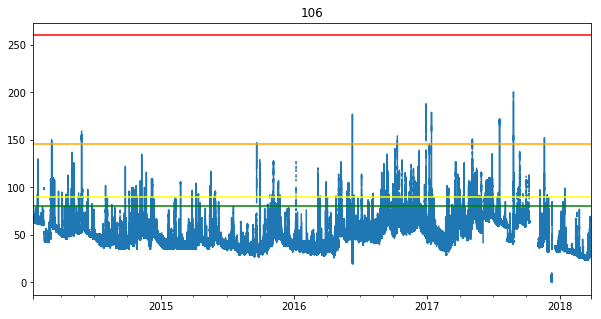

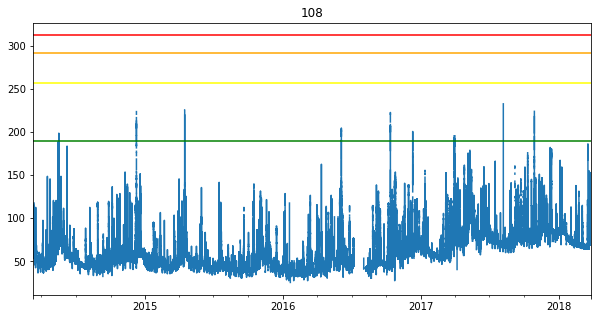

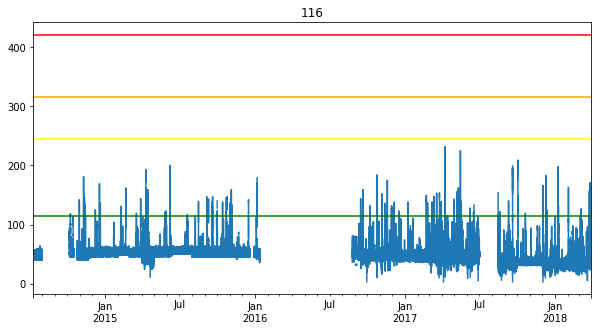

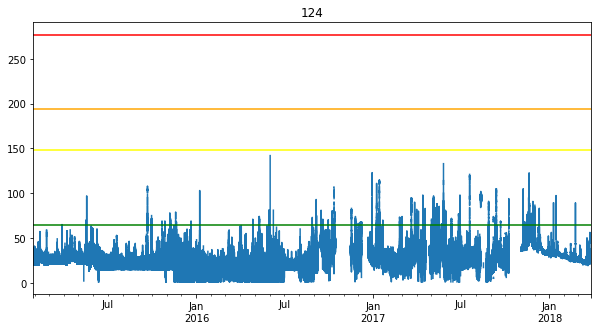

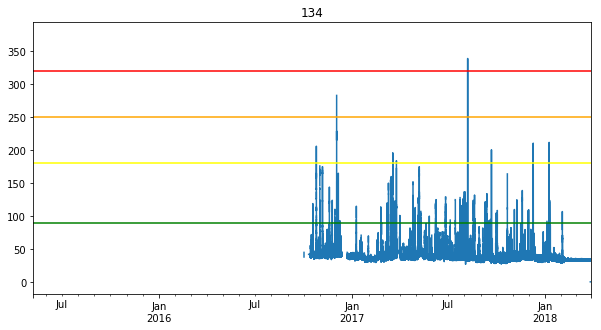

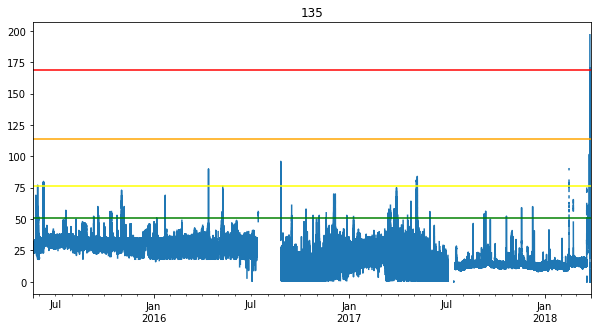

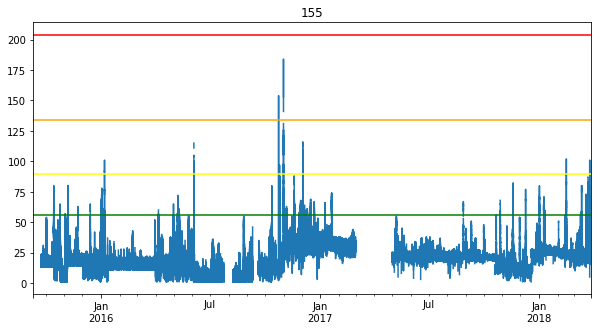

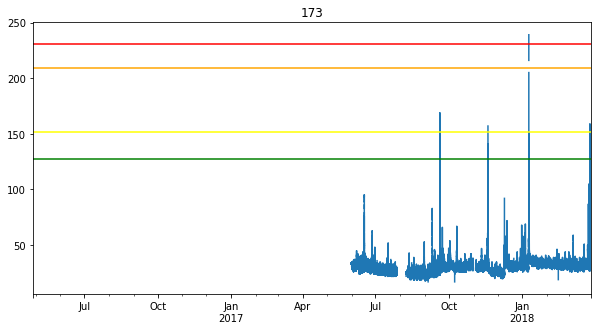

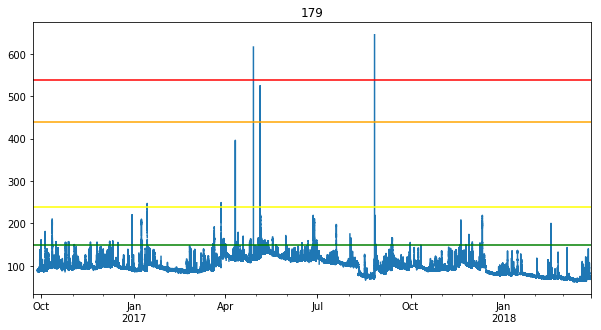

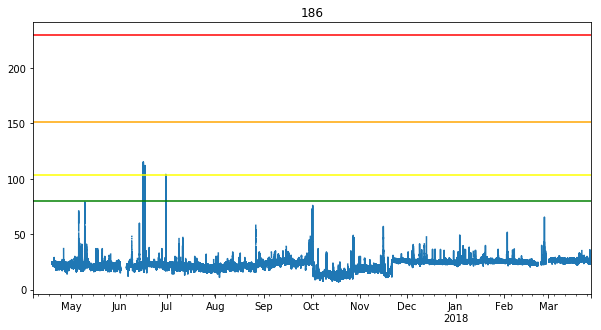

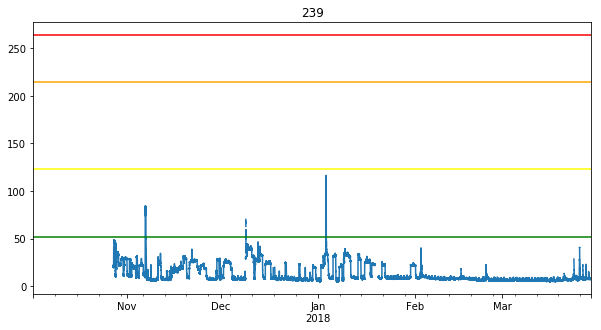

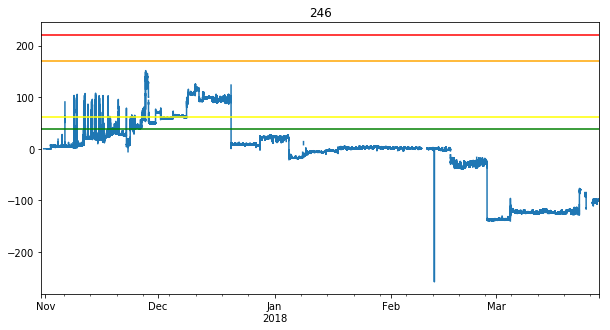

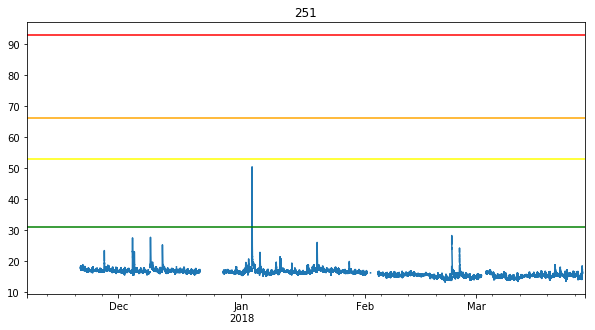

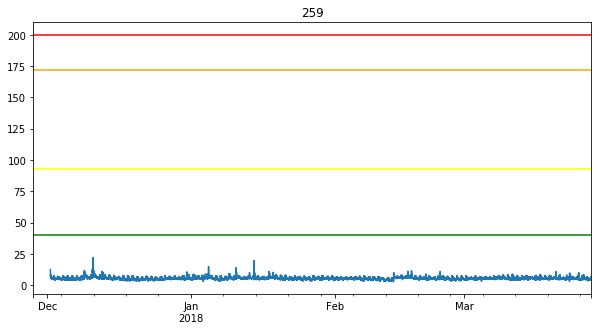

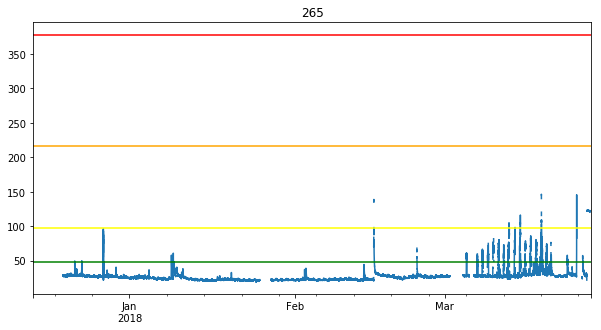

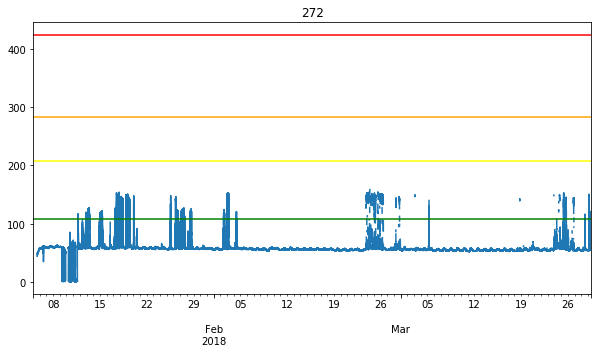

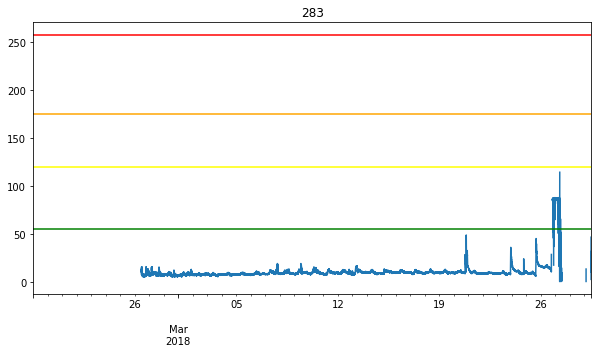

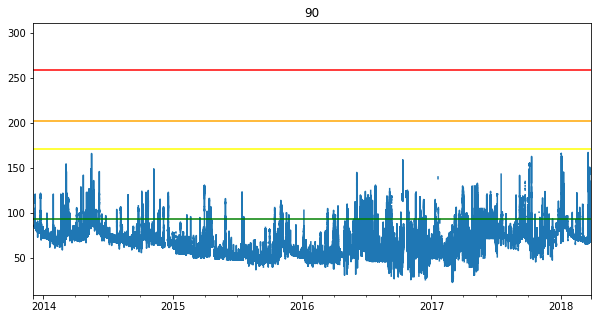

In [865]:
  
    pl.figure()
    nivel.plot(figsize=(10,5))
    colors=['g','yellow','orange','r']
    for index,i in enumerate(nrisk):
        pl.axhline(i,c=colors[index])
    pl.title(str(est))

### Generar Bandas .CSVs con eventos que superan N1 y sus estadísticas

##### Separar eventos Niveles.

PARA TODAS LAS N DE INTERÉS.

In [7]:
est_estadistico=np.array([106,108,179])
# threshold_estadistico=np.array([80,190,150])


Rutas y argumentos.

In [9]:
sirenas=np.hstack(dfconfig.index)
sirenas=sirenas[np.where(sirenas)[0]]
print sirenas

infoestaciones = self.infost
risklevels_all=infoestaciones[['action_level','minor_flooding','moderate_flooding','major_flooding']]

timeperiod='3 hours'
paths_n={}
for path in np.sort(glob.glob('/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/nivel/*.csv')):
    paths_n.update({path.split('/')[-1].split('_')[0]:path})
paths_p={}
for path in glob.glob('/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/pluvio/*.csv'):
    paths_p.update({path.split('/')[-1].split('_')[0]:path})


[216 219 220 221 222 223 224 226 279 280 285 300 301]


- Se sacan los eventos para todas las estaciones N asociadas a alarmas.
- Sólo los de las estaciones N más confiables, son los que se buscan en los pluvios.

In [1252]:
estsN=np.sort(np.hstack(dfconfig['EstNivel']))
estsN=estsN[np.where(estsN)[0]]

estN_out=[246,272,239, 173,186,251,259,283]

#     ests1=np.hstack(dfconfig[dfconfig.index==sir]['EstNivel1'])
#     ests=np.hstack(dfconfig[dfconfig.index==sir]['EstNivel'])
for est in np.unique(estsN):
    #las estaciones para las que no va a aplicar el analisis de eventos.
    if est in estN_out:
        pass
    else:
#         if est == 106:
        path_n=paths_n[str(est)]
        #se lee y organiza la serie
        nivel=pd.read_csv(path_n)
        nivel.index=pd.to_datetime(nivel[nivel.keys()[0]])
        nivel.index.name=''
        nivel=nivel.drop(nivel.keys()[0],axis=1)
        nivel.columns=['nivel']
        nivel=nivel['nivel']
        #nrisk
        nrisk=np.array(risklevels_all[risklevels_all.index==est])[0]
        #5min
        Ni=nivel.resample('5T').mean()
        #calidad
        Ni[Ni<=0]=np.nan
        Ni[Ni>nrisk[-1]*1.2]=np.nan
        if est in est_estadistico:
            nrisk[0]=threshold_estadistico[int(np.where(est_estadistico==int(est))[0])]
        umbralUP=nrisk[-1]*1.2
        umbralEV=nrisk[0]
        W_ahead=100
        # Ni=nivel
        #Se separan eventos
        Nima = np.ma.array(Ni.values, mask=Ni.values > umbralUP)
        G = fs.FindMax(Nima, Ni.index.to_pydatetime(), umbralEV, BusquedaAdelante=W_ahead)
        #Maximos en series de pandas
        Ev = pd.Series(np.hstack(np.array(Nima[G])), index=Ni.index[G])
        #numero de eventos.
        print Ev.size
        #se grafica y guardan hidrógrafas
        MatrizN=[]
        #     fig = pl.figure(figsize=(10,7))
        #     ax = fig.add_subplot(111)
        for p,i in enumerate(Ev.index):
            MatrizN.append(Ni[i - pd.Timedelta(timeperiod):i + pd.Timedelta(timeperiod)].values)
        dfnivel=pd.DataFrame(MatrizN).T
        dfnivel.columns=(map(str,Ev.index))
        dfnivel.to_csv('historicos/nivel/eventos/eventos_'+str(est)+'.csv')

        Nmax=pd.DataFrame(Ev)
        Nmax.to_csv('historicos/nivel/eventos/Nmax_'+str(est)+'.csv')

        n_perc=pd.DataFrame([dfnivel.T.quantile(0.1),dfnivel.T.quantile(0.25),dfnivel.T.quantile(0.50),dfnivel.T.quantile(0.75),dfnivel.T.quantile(0.90)]).T
        n_perc.to_csv('historicos/nivel/eventos/bandas_'+str(est)+'.csv')

291


### Eventos por pluvio!

Inputs

In [256]:
#correspondencia P-N
P_N={
    '3':[90,108],
    '18':[90,108],
    '43':[90,108],
    '29':[173,116],
    '1':[173,116],
    '8':[173,116],
    '9':[173,116],
    '33':[259,179,106],
    '253':[259,179,106],
    '234':[251,186],
    '30':[251,186],
    '12':[265,135],
    '14':[265,135,283,134],
    '48':[265,135,283,134],
    '89':[265,135,283,134],
    '267':[179,106,124],
    '261':[179,106,124,246],
    '61':[179,106,124,246],
    '70':[239],
    '248':[239],
    '281':[134,283],
    '121':[134,283],
    '88':[272],
    '31':[272],
    '37':[155],
    '74':[155]
    }

In [255]:
timeperiod='3 hours'
rutaNbandas='/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/nivel/eventos/'
rutaPbandas='/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/pluvio/eventos/'
#Estaciones que tienen historia de eventos.
paths=glob.glob(rutaNbandas+'Nmax*')
estsN=[i.split('/')[-1].split('_')[-1][:-4] for i in paths]
estN_out=[246,272,239, 173,186,251,259,283, 121]

Por cada pluvio, se leenlos eventos de las estaciones de nivel asociada a este. Haciendo excepción de las N que no tienen historia.

In [257]:
# Estaciones pluvio Al.
estsP=np.append(np.hstack(dfconfig['EstPluvioAdentro']),np.hstack(dfconfig['EstPluvioAfuera']))
estsP=np.unique(estsP[np.where(estsP)[0]])
estsP

array([u'1', u'12', u'121', u'14', u'18', u'234', u'248', u'253', u'261',
       u'267', u'281', u'29', u'3', u'30', u'31', u'33', u'37', u'43',
       u'48', u'61', u'70', u'74', u'8', u'88', u'89', u'9'],
      dtype='<U21')

Generacion de "estadisticos".

In [267]:
for est_p in estsP:
    print est_p
    # est_p='3'#estsP[0]
    #Se leen eventos de las estN asociadas.

    for N in P_N[est_p]:
        #Si no es un N que no tiene eventos.
        if N not in estN_out:
            Evdates=[]
            Nev=pd.read_csv(rutaNbandas+'Nmax_'+str(N)+'.csv')
            Evdates.append(np.array(Nev['Unnamed: 0'].values,dtype=np.datetime64))
            Evdates=np.sort(np.hstack(Evdates))

            # se descartan los eventos que estan cerca por mas de 3 horas, puede ser un repetido.
            Evdates_revised=[Evdates[0]]
            for index in range(Evdates.size-1):
                #si la difenrencia temporal de el evento i+1 y el i es mayor a 3 horas.
                if int(str((Evdates[index+1]-Evdates[index]).astype('timedelta64[h]')).split(' ')[0]) > 3:
                    print str(est_p)+'descartado '+str(index)
                    Evdates_revised.append(Evdates[index+1])

            #Se lee y organiza la serie historica del pluvio
            seriep=pd.read_csv(paths_p[est_p])
            seriep.index=pd.to_datetime(seriep[seriep.keys()[0]])
            seriep.index.name=''
            seriep=seriep.drop(seriep.keys()[0],axis=1)
            seriep.columns=['pluvio']
            seriep=seriep['pluvio']
            seriep=seriep.resample('5T').mean()

            #Generacion y guardado de estadisticos.

            #holders
            MatrizP=[];Pacum10d=[];Pacum3d=[];Pacum1d=[];Pacum3h=[];Pmax3h=[];EvP=[]

            for ev in Evdates_revised:
                #si la fecha  esta en la serieH pluvio
                if ev in seriep.index:
                    seriev=seriep[ev-pd.Timedelta(timeperiod):ev+pd.Timedelta(timeperiod)]
            #         # si hay mas de dos cazoletazos, para filtrar ceros y lluvias peque.
            #         if seriev.max()>0.5:

                    #si menos del 15% son no nan - datos interesantes.
                    if (seriev.dropna().size)/float(seriev.size) < 0.5:
                        pass
                    else:
                        #si puede guarde los eventos, try porque las serie N y P no siempre coinciden.
                        try:
                            MatrizP.append(seriev.values)
                            Pacum10d.append(seriep[ev-pd.Timedelta('10 days'):ev].sum())
                            Pacum3d.append(seriep[ev-pd.Timedelta('3 days'):ev].sum())
                            Pacum1d.append(seriep[ev-pd.Timedelta('1 days'):ev].sum())
                            Pacum3h.append(seriep[ev-pd.Timedelta('3 hours'):ev].sum())
                            Pmax3h.append(seriep[ev-pd.Timedelta('3 hours'):ev].max())
                            EvP.append(ev)
                        except:
                            pass
                #si el evento no esta en la serie, pone a todo NaN
                else:
                    MatrizP.append(np.ones(seriev.size)*np.nan)
                    Pacum10d.append(np.nan)
                    Pacum3d.append(np.nan)
                    Pacum1d.append(np.nan)
                    Pacum3h.append(np.nan)
                    Pmax3h.append(np.nan)
                    EvP.append(ev)

            #Guardado.
            dfpluvio=pd.DataFrame(MatrizP).T
            dfpluvio.columns=(map(str,EvP))
            dfpluvio.to_csv(rutaPbandas+'eventos_'+str(est_p)+'.csv')

            #bandas - acumulacionP
            dfpluvio=dfpluvio.fillna(method='ffill')
            Pbandas=pd.DataFrame([dfpluvio.cumsum().T.quantile(0.1),dfpluvio.cumsum().T.quantile(0.25),dfpluvio.cumsum().T.quantile(0.5),dfpluvio.cumsum().T.quantile(0.75),dfpluvio.cumsum().T.quantile(0.9)]).T
            Pbandas.to_csv(rutaPbandas+'bandas_'+str(est_p)+'.csv')

            Pacum=pd.DataFrame([Pacum3h,Pacum1d,Pacum3d,Pacum10d,Pmax3h])
            Pacum.index=['Pacum3h','Pacum1','Pacum3','Pacum10','Pmax3h']
            Pacum.columns=(map(str,EvP))
            Pacum.to_csv(rutaPbandas+'Pacum_'+str(est_p)+'.csv')
        # si si no hace nada
        else: 
            pass

1
1descartado 0
1descartado 1
1descartado 2
1descartado 3
1descartado 4
1descartado 5
1descartado 6
1descartado 7
1descartado 8
1descartado 9
1descartado 10
1descartado 11
1descartado 12
1descartado 13
1descartado 14
1descartado 15
1descartado 16
1descartado 17
1descartado 18
1descartado 19
1descartado 20
1descartado 21
1descartado 22
1descartado 23
1descartado 24
1descartado 25
1descartado 26
1descartado 27
1descartado 28
1descartado 29
1descartado 30
1descartado 31
1descartado 32
1descartado 33
1descartado 34
1descartado 35
1descartado 36
1descartado 37
1descartado 38
1descartado 39
1descartado 40
1descartado 41
1descartado 42
1descartado 43
1descartado 44
1descartado 45
1descartado 46
1descartado 47
1descartado 48
1descartado 49
1descartado 50
1descartado 51
1descartado 52
1descartado 53
1descartado 54
1descartado 55
1descartado 56
1descartado 57
1descartado 58
1descartado 59
1descartado 60
1descartado 61
1descartado 62
1descartado 63
1descartado 64
1descartado 65
1descartado 66
1de

18descartado 0
18descartado 1
18descartado 2
18descartado 3
18descartado 4
18descartado 5
234
248
253
253descartado 0
253descartado 1
253descartado 2
253descartado 3
253descartado 4
253descartado 5
253descartado 6
253descartado 7
253descartado 8
253descartado 9
253descartado 10
253descartado 11
253descartado 12
253descartado 13
253descartado 14
253descartado 15
253descartado 16
253descartado 17
253descartado 18
253descartado 19
253descartado 20
253descartado 21
253descartado 22
253descartado 23
253descartado 24
253descartado 25
253descartado 26
253descartado 27
253descartado 28
253descartado 29
253descartado 30
253descartado 32
253descartado 33
253descartado 34
253descartado 35
253descartado 36
253descartado 37
253descartado 38
253descartado 39
253descartado 40
253descartado 41
253descartado 42
253descartado 43
253descartado 44
253descartado 45
253descartado 46
253descartado 47
253descartado 48
253descartado 49
253descartado 50
253descartado 0
253descartado 1
253descartado 2
253descart

261descartado 0
261descartado 1
261descartado 2
261descartado 3
261descartado 4
261descartado 5
261descartado 6
261descartado 7
261descartado 8
261descartado 9
261descartado 10
261descartado 11
261descartado 12
261descartado 13
261descartado 14
261descartado 15
261descartado 16
261descartado 17
261descartado 18
261descartado 19
261descartado 20
261descartado 21
261descartado 22
261descartado 23
261descartado 24
261descartado 25
261descartado 26
261descartado 27
261descartado 28
261descartado 29
261descartado 30
261descartado 31
261descartado 32
261descartado 33
261descartado 34
261descartado 35
261descartado 36
261descartado 37
261descartado 38
261descartado 39
261descartado 40
261descartado 41
261descartado 42
261descartado 43
261descartado 44
261descartado 45
261descartado 46
261descartado 47
261descartado 48
261descartado 49
261descartado 50
261descartado 51
261descartado 52
261descartado 53
261descartado 54
261descartado 55
261descartado 56
261descartado 57
261descartado 58
261desc

281
281descartado 0
281descartado 1
281descartado 2
281descartado 3
281descartado 4
281descartado 5
281descartado 6
281descartado 7
281descartado 8
281descartado 9
281descartado 10
281descartado 11
281descartado 12
281descartado 13
281descartado 14
281descartado 15
281descartado 16
281descartado 17
281descartado 18
281descartado 19
281descartado 20
281descartado 21
281descartado 22
281descartado 23
281descartado 24
281descartado 25
281descartado 26
281descartado 27
281descartado 28
281descartado 29
281descartado 30
281descartado 31
281descartado 32
281descartado 33
281descartado 34
281descartado 35
281descartado 36
281descartado 37
281descartado 38
281descartado 39
281descartado 40
281descartado 41
281descartado 42
281descartado 43
281descartado 44
281descartado 45
281descartado 46
281descartado 47
281descartado 48
281descartado 49
281descartado 50
281descartado 51
281descartado 52
29
29descartado 0
29descartado 1
29descartado 2
29descartado 3
29descartado 4
29descartado 5
29descartado

37
37descartado 0
37descartado 1
37descartado 2
37descartado 3
37descartado 4
37descartado 5
37descartado 6
37descartado 7
37descartado 8
37descartado 9
37descartado 10
37descartado 11
37descartado 12
37descartado 13
37descartado 14
37descartado 15
37descartado 16
37descartado 17
37descartado 18
37descartado 19
37descartado 20
37descartado 21
37descartado 22
37descartado 23
37descartado 24
37descartado 25
37descartado 26
37descartado 27
37descartado 28
37descartado 29
37descartado 30
37descartado 31
37descartado 32
37descartado 33
37descartado 34
37descartado 35
37descartado 36
37descartado 37
43
43descartado 0
43descartado 1
43descartado 2
43descartado 3
43descartado 4
43descartado 5
43descartado 6
43descartado 7
43descartado 8
43descartado 9
43descartado 10
43descartado 11
43descartado 12
43descartado 13
43descartado 14
43descartado 15
43descartado 16
43descartado 17
43descartado 18
43descartado 19
43descartado 20
43descartado 21
43descartado 22
43descartado 23
43descartado 25
43desc

61descartado 0
61descartado 1
61descartado 2
61descartado 3
61descartado 4
61descartado 5
61descartado 6
61descartado 7
61descartado 8
61descartado 9
61descartado 10
61descartado 11
61descartado 12
61descartado 13
61descartado 14
61descartado 15
61descartado 16
61descartado 17
61descartado 18
61descartado 19
61descartado 20
61descartado 21
61descartado 22
61descartado 23
61descartado 24
61descartado 25
61descartado 26
61descartado 27
61descartado 28
61descartado 29
61descartado 30
61descartado 31
61descartado 32
61descartado 33
61descartado 34
61descartado 35
61descartado 36
61descartado 37
61descartado 38
61descartado 39
61descartado 40
61descartado 41
61descartado 42
61descartado 43
61descartado 44
61descartado 45
61descartado 46
61descartado 47
61descartado 48
61descartado 49
61descartado 50
61descartado 51
61descartado 52
61descartado 53
61descartado 54
61descartado 55
61descartado 56
61descartado 57
61descartado 58
61descartado 59
61descartado 60
61descartado 61
61descartado 62
61

In [ ]:
1,12,121,14,18,253,261,267,281,29,3,33,37,43,48

In [264]:
Pbandas=pd.read_csv(rutaPbandas+'bandas_281.csv')

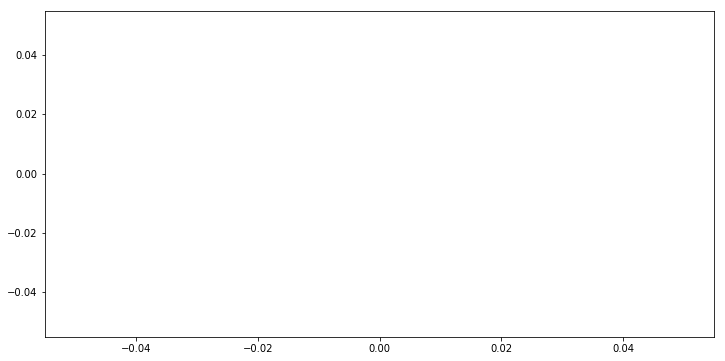

In [265]:
#FIGURE
fig=pl.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.fill_between(np.arange(Pbandas['0.1'].size),Pbandas['0.1'],Pbandas['0.9'],color='c',alpha=0.3,label='$P_{10-90}$')
ax.plot(Pbandas['0.5'],color='darkcyan',label='Mediana',lw=3)

### Funciones para Figuras

Nuevas rutas a definir en el configfile

#Rutas
ruta_estadistico='/media/nicolas/Home/Jupyter/Esneider/modelo_crecidas/pronostico_niveles.bin'
rutaN='/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/nivel/eventos/'
rutafigsN='/media/nicolas/Home/Jupyter/Soraya/Op_Alarmas/Result_to_web/Figuras_Alarmas/nivel/'
#rutas
ruta_pluvioforecast='/media/nicolas/Home/Jupyter/Esneider/Lluvia_operacional/Salidas/'
rutaP='/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/historicos/pluvio/eventos/'
rutafigsP='/media/nicolas/Home/Jupyter/Soraya/Op_Alarmas/Result_to_web/Figuras_Alarmas/pluvio/'

Cosas que deben ir en el cron

In [2]:
#Lectura de ruta de configuracion.
ruta_config= '/media/nicolas/Home/Jupyter/Soraya/git/Alarmas/04_web_hidrologia/hidrologia/configfile_web.md'
listconfig = al.get_rutesList(ruta_config)

#Lectura de rutas
ruta_estadistico=al.get_ruta(listconfig,'ruta_estadistico')
ruta_pluvioforecast=al.get_ruta(listconfig,'ruta_pluvioforecast')
rutaN_infoeventos=al.get_ruta(listconfig,'rutaN_infoeventos')
rutaP_infoeventos=al.get_ruta(listconfig,'rutaP_infoeventos')
rutaFigsNbandas=al.get_ruta(listconfig,'rutaFigsNbandas')
rutaFigsPbandas=al.get_ruta(listconfig,'rutaFigsPbandas')
#Lectura del assignfile
dfconfig=pd.read_json(al.get_ruta(listconfig,'ruta_JSONinfosirenas'))

In [3]:
timedeltaEv=5#min
# label time
hours=np.arange(-3,4)
rng1=[]
for i in range(hours.size):
    if hours[i]<0:
        rng1.append('-0'+str(np.abs(hours[i]))+':00')
    else:
        rng1.append('0'+str(np.abs(hours[i]))+':00')
rng1=np.array(rng1)

In [4]:
#Estadistico
# se lee la info del pronostico Estadistico 30m
f=open(ruta_estadistico)
n_pronos1=pickle.load(f)
f.close()
n_pronos=pd.DataFrame(n_pronos1)
columns=['codigo','n30p25','n30p50','n30p75','Ttop25','Ttop50','Ttop75']
n_pronos.columns=columns
n_pronos['codigo']=map(int,n_pronos['codigo'])
n_pronos.index=n_pronos['codigo']
n_pronos=n_pronos.drop('codigo',axis=1)
n_pronos=n_pronos.T

funcion

In [ ]:
def plotN_vs_History(dfconfig,n_pronos,rutaN,rutaP,rutafigsN,rutafigsP,rng1,timedeltaEv):
    ests=np.unique(np.hstack(dfconfig['EstNivel']))
    ests=ests[np.where(ests)[0]]
    ests_n1=np.hstack(dfconfig['EstNivel1'])
    ests_n1=ests_n1[np.where(ests_n1)[0]]
    est_outfig=[246,272,239,173,186,251,259,283,155]

    for est in np.unique(ests_n1)[:2]:
        if est in est_outfig:
            pass
        else:
            #Eventos.
            Nmax=pd.read_csv(rutaN+'Nmax_'+str(est)+'.csv')
            df=Nmax
            df.index=pd.to_datetime(df[df.keys()[0]])
            df.index.name=''
            Nmax=df.drop(df.keys()[0],axis=1)

            #BandasN
            Nbandas=pd.read_csv(rutaN+'bandas_'+str(est)+'.csv')

            #Consulta ultimas 3 horas.
            self= cpr.Nivel(est)
            start=(dt.datetime.now()-pd.Timedelta('3 hours')).strftime('%Y-%m-%d-%H:%M')
            end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
            level=self.get_level(start,end)
            level=(level['nivel'].resample('5T').mean())

            #Figura Nshape
            if int(est) in n_pronos.columns:
                if n_pronos[int(est)].all() == 0:
                    na=0;nb=0;nc=0
                    ta=0;tb=0;tc=0
                    #cosas para plotear - se plotea normal.
                    serie_obs=level.values
                    serie_xEst=level.size+((60/timedeltaEv)/2)
                #si no
                else:
                    na=n_pronos[est]['n30p25'];nb=n_pronos[est]['n30p50'];nc=n_pronos[est]['n30p75']
                    ta=n_pronos[est]['Ttop25'];tb=n_pronos[est]['Ttop50'];tc=n_pronos[est]['Ttop75']
#                     nb=75
                    #cosas para plotear
                    #si N30m es mayor que observado
                    if nb > level[-1]:
                        serie_obs=level.values[(60/timedeltaEv)/2:]
                        serie_xEst=level.size
                    #si N30m es menor que observado
                    elif nb <= level[-1]:
                        stepback=level.size-level.values.argmax() 
                        serie_obs=np.append(np.ones(stepback)*level[0],level.values)##hacer la consulta más larguita!!!!
                        serie_xEst=serie_n.size+(60/timedeltaEv)/2
                    else:
                        print 'No se define serie a plotear.'
            #figura
            fig=pl.figure(figsize=(12,6))
            ax=fig.add_subplot(111)
            ax.fill_between(np.arange(Nbandas['0.1'].size),Nbandas['0.1'],Nbandas['0.9'], color = 'c', alpha = 0.3,label='$P_{10-90}$')
            ax.plot(Nbandas['0.5'],color='darkcyan',label='Mediana',lw=2)
            ax.plot(serie_obs,c='k',lw=3,label='Nobs')
            if nb==0:
                pass
            else:
                pl.scatter(serie_xEst,nb,c='crimson',marker='^',s=100,label=u'Nmáx30')
            ax.set_title('Est. '+ str(est)+' - '+str(Nmax['0'].size)+' Eventos',fontsize=21)
            ax.set_ylabel('Nivel $[cm]$', size= 19)
            ax.set_xlabel(u'Tiempo respecto al Nmáx', size= 19)
            ax.tick_params(labelsize=14.5)
            ax.set_xticks(np.arange(0,Nbandas.shape[0],60/timedeltaEv))
            ax.set_xticklabels(rng1)
            legend = ax.legend(fontsize=17,bbox_to_anchor =(0.69,-0.120),ncol=2)
            pl.savefig(rutafigsN+'Nshape_'+str(est)+'.png',bbox_inches='tight',bbox_extra_artists=[legend])

            #Figura Nhist
            fig=pl.figure(figsize=(8,6))
            ax=fig.add_subplot(111)
            pl.hist(Nmax['0'],color='darkcyan')
            pl.axvline(level[-1],c='greenyellow',lw=2,label='Nobs')
            if nb==0:
                pass
            else:
                pl.axvline(nb,c='greenyellow',lw=2,label=u'Nmáx_30',ls='--')
            ax.set_title('Est. '+ str(est)+' - '+str(Nmax['0'].size)+' Eventos',fontsize=21)
            ax.set_ylabel('Frecuencia ', size= 19)
            ax.set_xlabel(u'N máx. $[m]$', size= 19)
            ax.tick_params(labelsize=14.5)
            legend = ax.legend(fontsize=17,bbox_to_anchor =(0.76,-0.170),ncol=2)
            pl.savefig(rutafigsN+'Nhist_'+str(est)+'.png',bbox_inches='tight',bbox_extra_artists=[legend])

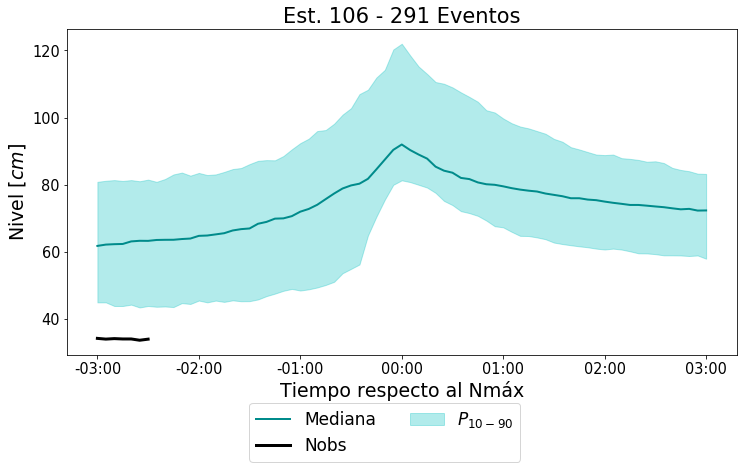

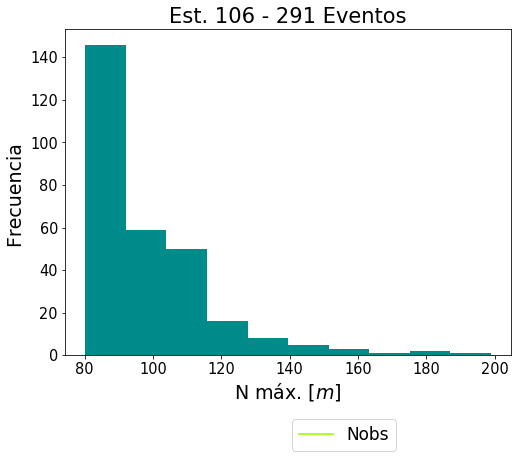

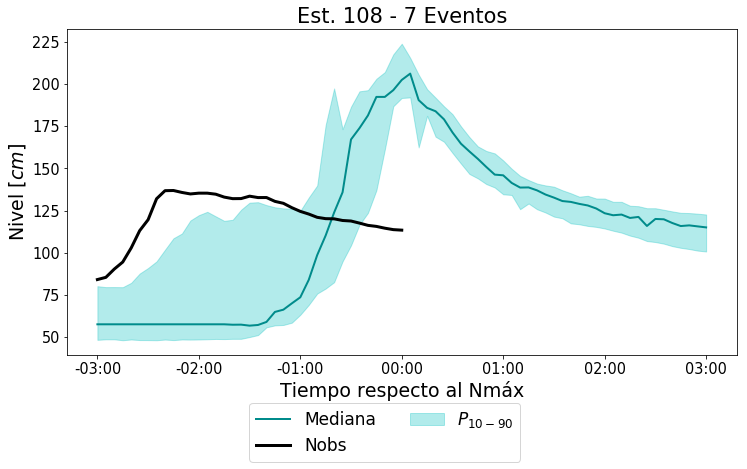

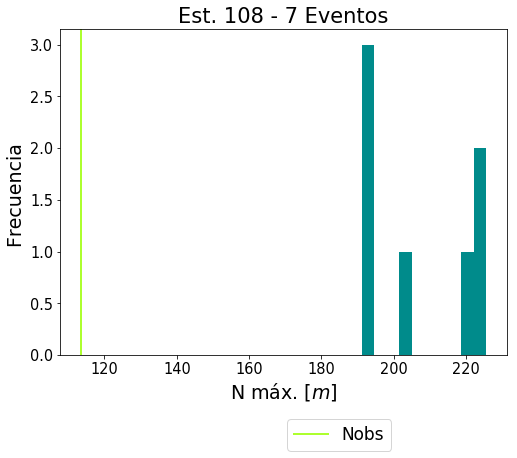

In [21]:
plotN_vs_History(dfconfig,n_pronos,rutaN,rutaP,rutafigsN,rutafigsP,rng1,timedeltaEv)

Prueba desde el modulo.

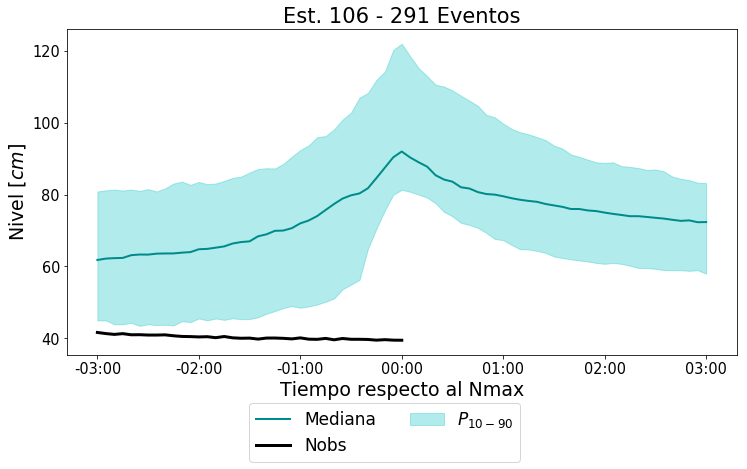

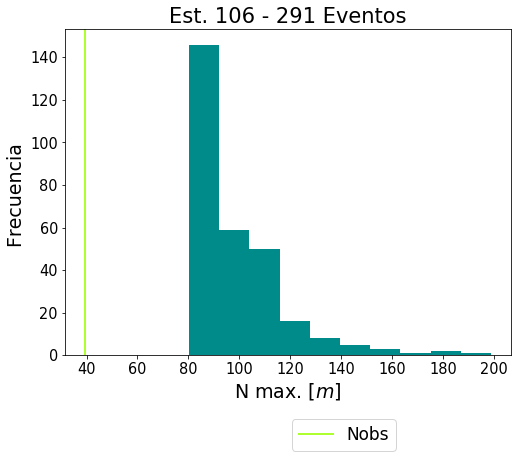

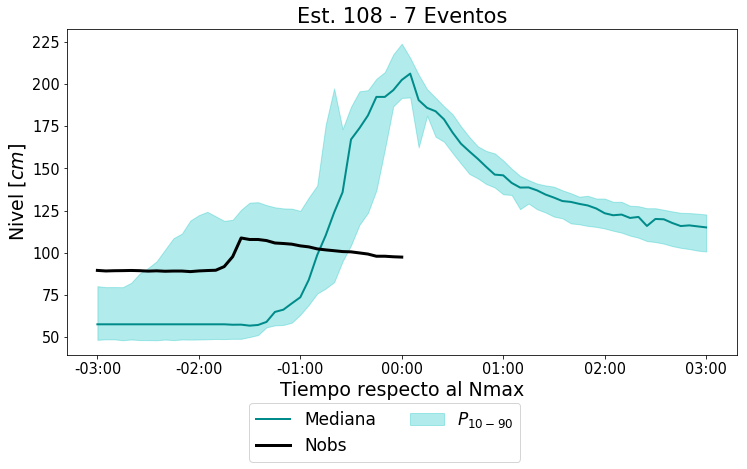

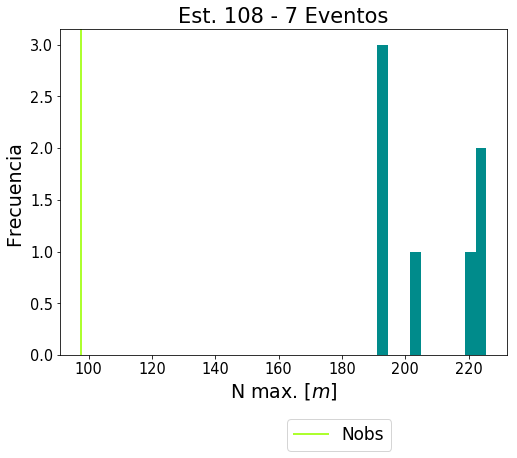

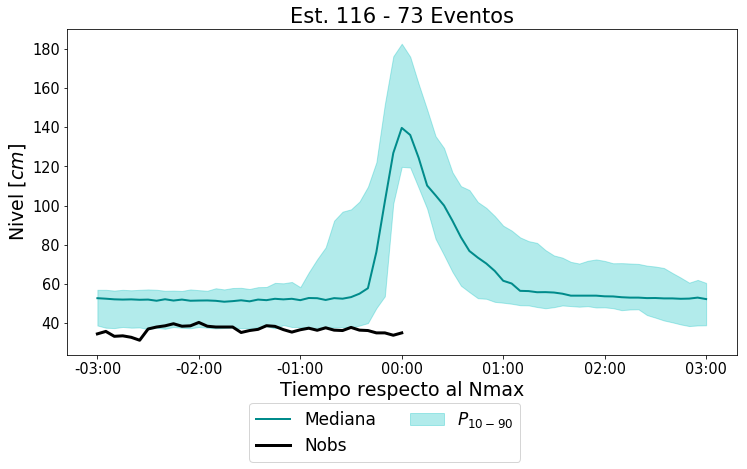

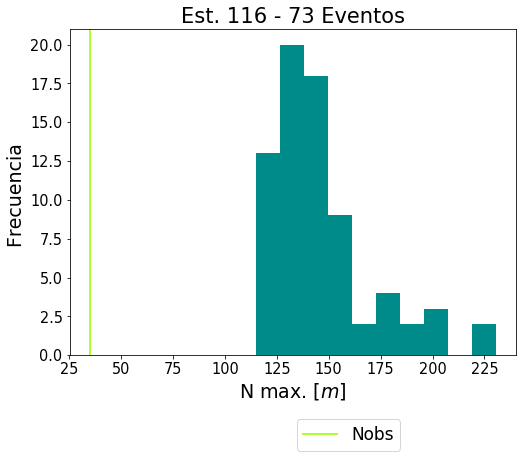

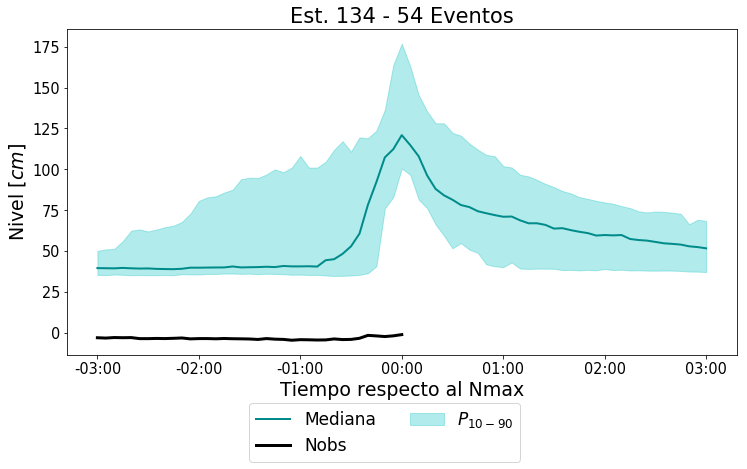

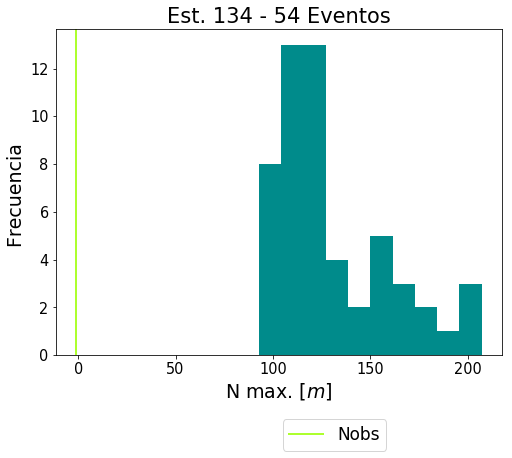

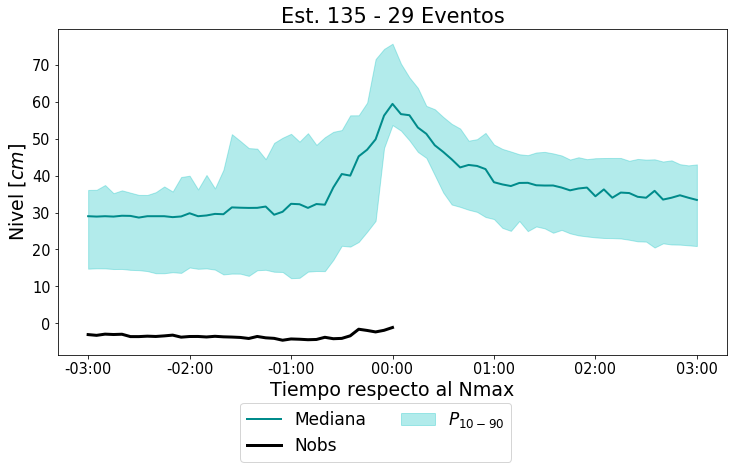

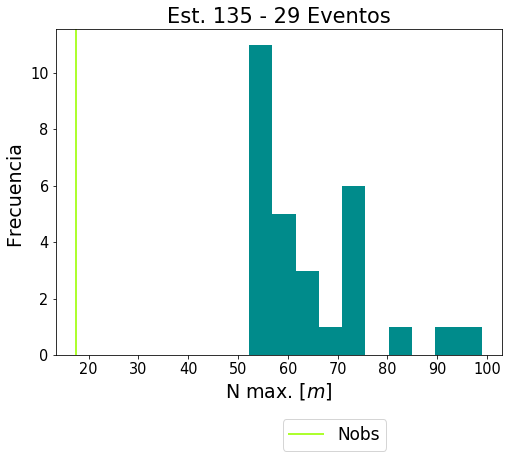

In [5]:
al.plotN_vs_History(dfconfig,n_pronos,rutaN_infoeventos,rutaFigsNbandas,rng1,timedeltaEv)

#### Pluvio

cast_normal
rutaP
rutafigsP

#este se corre solo cuando el pronostico de lluvia sea diferente de cero.
#o cuando el el acumulado final sea diferente de cero.
#un solo pico

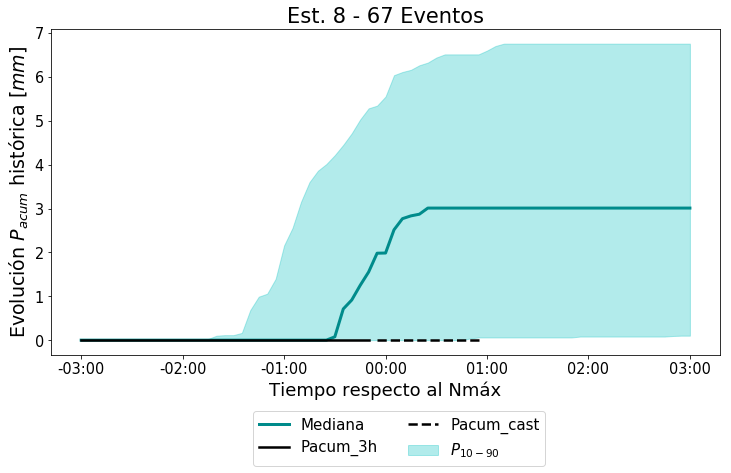

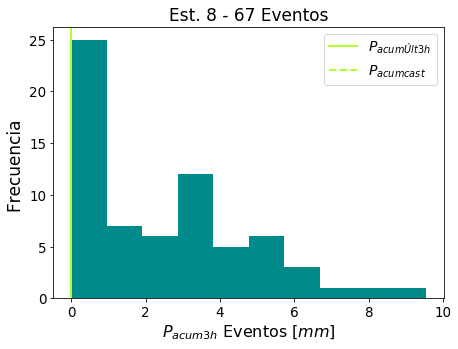

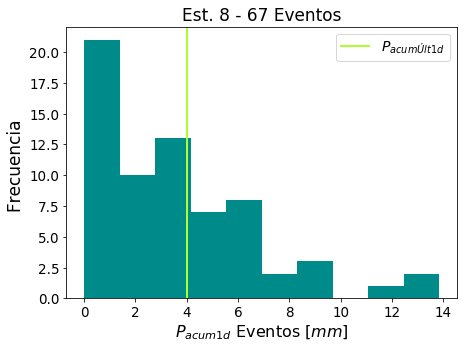

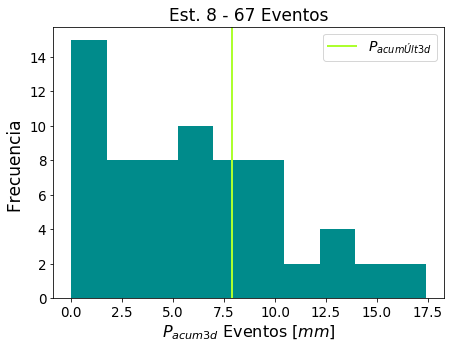

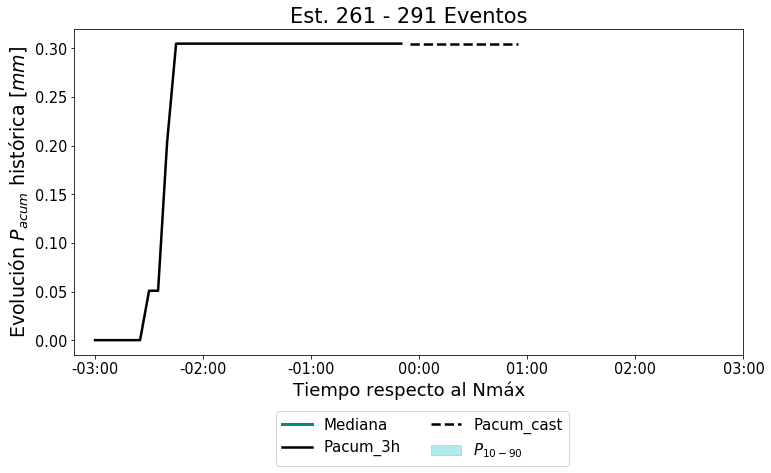

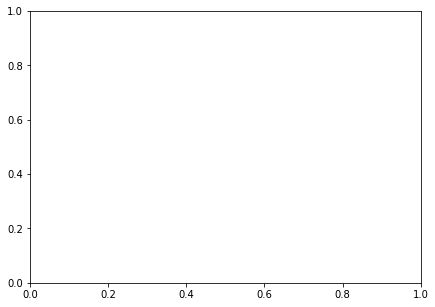

In [24]:
plotP_vs_History(rutaP,rutafigsP,cast_normal,ests_p)

Prueba funcion en modulo

In [5]:
f = open(ruta_pluvioforecast+'_cast_normal.rain','r')
cast_normal = pickle.load(f)
f.close()


In [7]:
def plotP_vs_History(rutaP,rutafigsP,cast_normal,rng1,timedeltaEv):
    est_tocorrect=[267,261,253,281]
    #se leen las est a plotear
    paths=glob.glob(rutaP+'bandas*')
    ests_p=[i.split('/')[-1].split('_')[-1][:-4] for i in paths]
    #for para todas
    for est_p in np.sort(ests_p):
        if int(est_p) in est_tocorrect:
            pass
        else:
            #bandas
            Pbandas=pd.read_csv(rutaP+'bandas_'+str(est_p)+'.csv')
            #Pacum
            Pacum=pd.read_csv(rutaP+'Pacum_'+str(est_p)+'.csv')
            Pacum.index=Pacum[Pacum.keys()[0]]
            Pacum=Pacum.drop(Pacum.keys()[0],axis=1)
            #consulta
            start=(dt.datetime.now()-pd.Timedelta('10 days')).strftime('%Y-%m-%d-%H:%M')
            end=dt.datetime.now().strftime('%Y-%m-%d-%H:%M')
            self = cpr.Pluvio(int(est_p))
            pluvio = self.read_pluvio(start,end)
            pluvio=(pluvio.resample('5T').mean())
            P3h=pluvio[pd.to_datetime(end)-pd.Timedelta('3 hours'):][:-1]
            #Pacum
            Pacum1d=pluvio[pd.to_datetime(end)-pd.Timedelta('1 days'):][:-1].sum()
            Pacum3d=pluvio[pd.to_datetime(end)-pd.Timedelta('3 days'):][:-1].sum()
            Pacum10d=pluvio[pd.to_datetime(end)-pd.Timedelta('10 days'):][:-1].sum()
            #Consulta
            P6h=pluvio[pd.to_datetime(end)-pd.Timedelta('6 hours'):][:-1]
            pos0=P6h.index.get_loc(P3h.index[0])
            P3h=P6h[pd.to_datetime(end)-pd.Timedelta('3 hours'):]
            P=P3h.append(cast_normal[str(est_p)])

            #que plotear
            #cast cero, no esta lloviendo
            if cast_normal[str(est_p)].all() == 0:
    #                 print 'aqui'
                Yo=P.cumsum()[:-(60/timedeltaEv)-1]
                Xo=np.arange(0,Yo.size)
                Yc=P.cumsum()[-(60/timedeltaEv)-1:]
                Xc=np.arange(P3h.size,P.size)
            else:
    #                 print 'aqui1'
                #pongo cast en la mitad, recortando la serie.
                if P.sum() > P3h.sum():
    #                     print 'aqui2'
                    Yo=P3h.cumsum()[(60/timedeltaEv)+1:]
                    Xo=np.arange(0,Yo.size)
                    Yc=P.cumsum()[-(60/timedeltaEv)-1:]
                    Xc=np.arange(Yo.size,Yo.size+Yc.size)
                #pongo maximo en la mitad, alargando la serie hacia atras.
                elif P.sum() <= P3h.sum():
    #                     print 'aqui3'
                    stepback=60/timedeltaEv#P3h.size-P3h.values.argmax()
                    Yo=P6h[pos0-stepback:].cumsum()
                    Xo=np.arange(0,Yo.size)
                    Yc=P.cumsum()[-(60/timedeltaEv):]
                    Xc=np.arange(Yo.size,Yo.size+Yc.size)
                else:
                    print 'no hay series para graficar'
            #FIGURE
            fig=pl.figure(figsize=(12,6))
            ax=fig.add_subplot(111)
            ax.fill_between(np.arange(Pbandas['0.1'].size),Pbandas['0.1'],Pbandas['0.9'],color='c',alpha=0.3,label='$P_{10-90}$')
            ax.plot(Pbandas['0.5'],color='darkcyan',label='Mediana',lw=3)
            ax.plot(Xo,Yo.values,c='k',lw=2.5,label='Pacum_3h')
            ax.plot(Xc,Yc.values,c='k',lw=2.5,ls='--',label='Pacum_cast')
            ax.set_ylabel(u'Evolucion $P_{acum}$ historica $[mm]$', size= 19)
            ax.set_xlabel(u'Tiempo respecto al Nmax', size= 18)
            ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=21)
            ax.tick_params(labelsize=14.5)
            ax.set_xticks(np.arange(0,Pbandas.shape[0],60/timedeltaEv))
            ax.set_xticklabels(rng1)
            # ax.set_ylim(0,int(Pbandas['0.9'].max()+1))
            # ax.legend(fontsize=17,loc=(0.045,-0.225),ncol=3)
            # pl.savefig(rutafigsP+'Pshape_'+str(est)+'.png')
            legend = ax.legend(fontsize=15,bbox_to_anchor =(1.5/2,-0.150),ncol=2)
            pl.savefig(rutafigsP+'Pshape_'+str(est_p)+'.png',bbox_inches='tight',bbox_extra_artists=[legend])
            #Pacum3h
            fig=pl.figure(figsize=(7,5))
            ax=fig.add_subplot(111)
            pl.hist(np.array(Pacum[Pacum.index=='Pacum3h'])[0],color='darkcyan')
            pl.axvline(P3h.sum(),c='greenyellow',lw=2,label=u'$P_{acumUlt3h}$')
            pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
            ax.set_ylabel('Frecuencia ', size= 17)
            ax.set_xlabel(u'$P_{acum3h}$ Eventos $[mm]$', size= 16)
            ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=17)
            ax.tick_params(labelsize=13.5)
            ax.legend(fontsize=14)
            pl.savefig(rutafigsP+'Phist3h_'+str(est_p)+'.png')
            #Pacum1d
            fig=pl.figure(figsize=(7,5))
            ax=fig.add_subplot(111)
            pl.hist(np.array(Pacum[Pacum.index=='Pacum1'])[0],color='darkcyan')
            pl.axvline(Pacum1d,c='greenyellow',lw=2,label=u'$P_{acumUlt1d}$')
            ax.set_ylabel('Frecuencia ', size= 17)
            ax.set_xlabel(u'$P_{acum1d}$ Eventos $[mm]$', size= 16)
            ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=17)
            ax.tick_params(labelsize=13.5)
            ax.legend(fontsize=14)
            pl.savefig(rutafigsP+'pruebas/Phist1d_'+str(est_p)+'.png')
            #Pacum3d
            fig=pl.figure(figsize=(7,5))
            ax=fig.add_subplot(111)
            pl.hist(np.array(Pacum[Pacum.index=='Pacum3'])[0],color='darkcyan')
            pl.axvline(Pacum3d,c='greenyellow',lw=2,label=u'$P_{acumUlt3d}$')
            #pl.axvline(P.sum(),c='greenyellow',lw=2,label=u'$P_{acumcast}$',ls='--')
            ax.set_ylabel('Frecuencia ', size= 17)
            ax.set_xlabel(u'$P_{acum3d}$ Eventos $[mm]$', size= 16)
            ax.set_title('Est. '+ str(est_p)+' - '+str(np.array(Pacum[Pacum.index=='Pacum3h'])[0].size)+' Eventos',fontsize=17)
            ax.tick_params(labelsize=13.5)
            ax.legend(fontsize=14)
            pl.savefig(rutafigsP+'pruebas/Phist3d_'+str(est_p)+'.png')

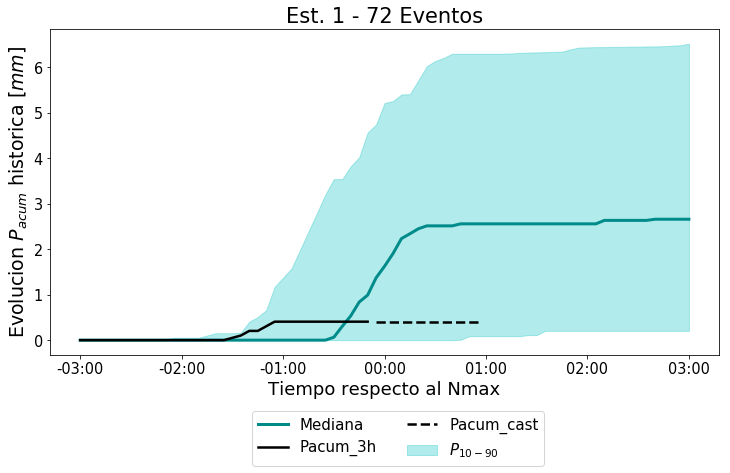

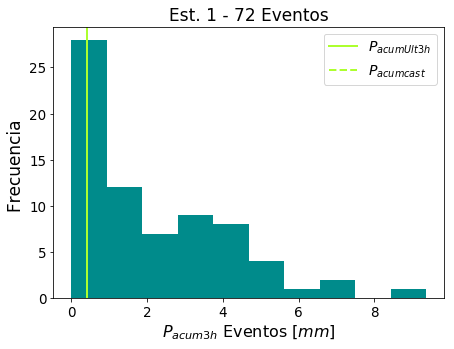

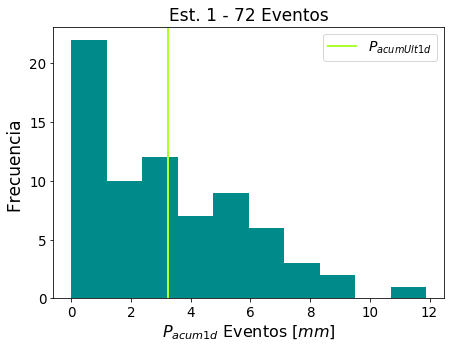

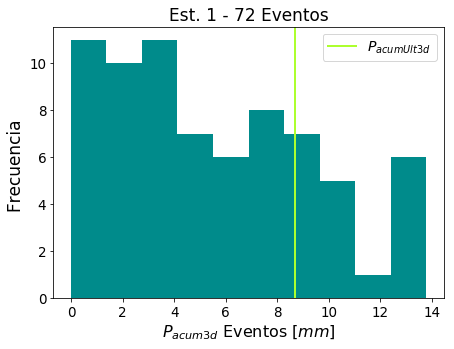

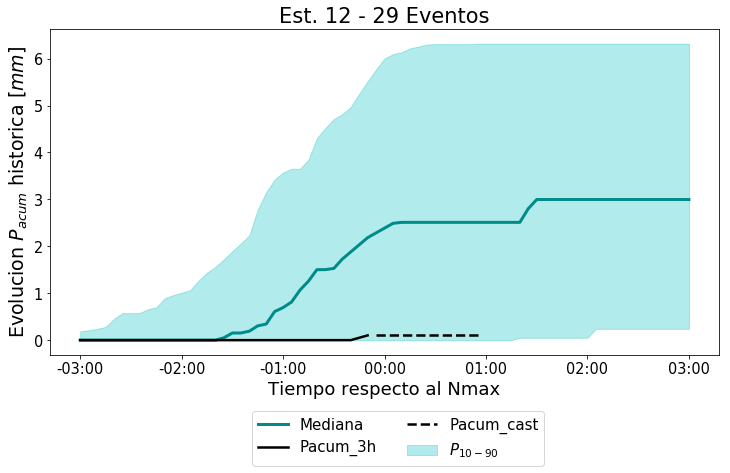

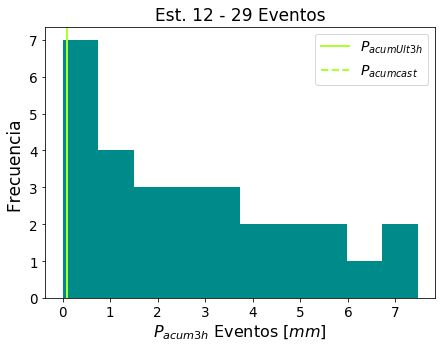

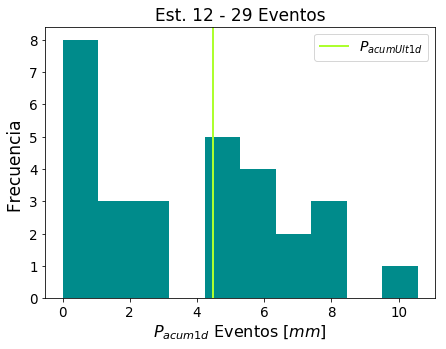

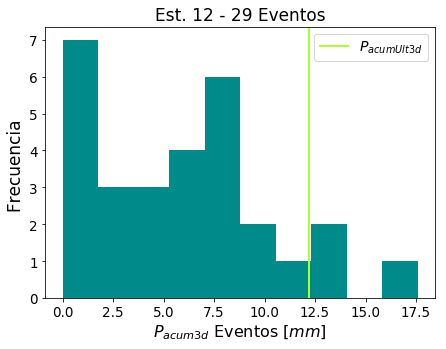

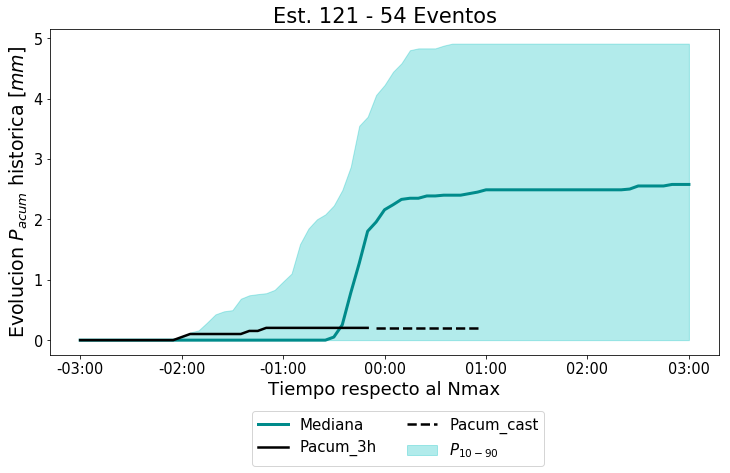

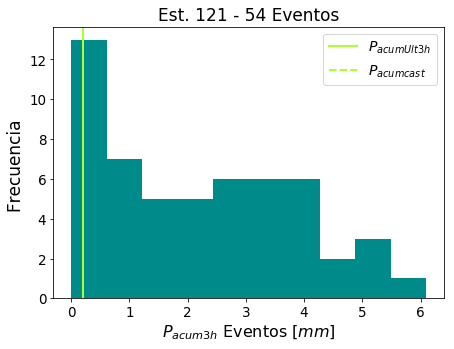

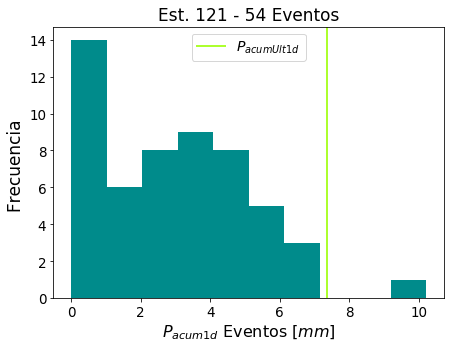

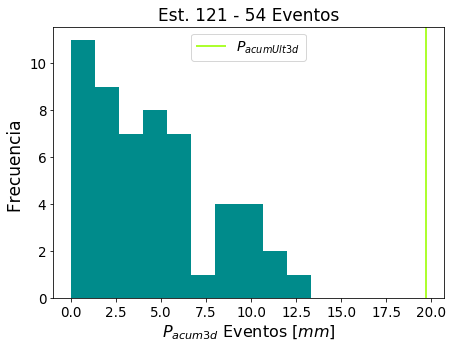

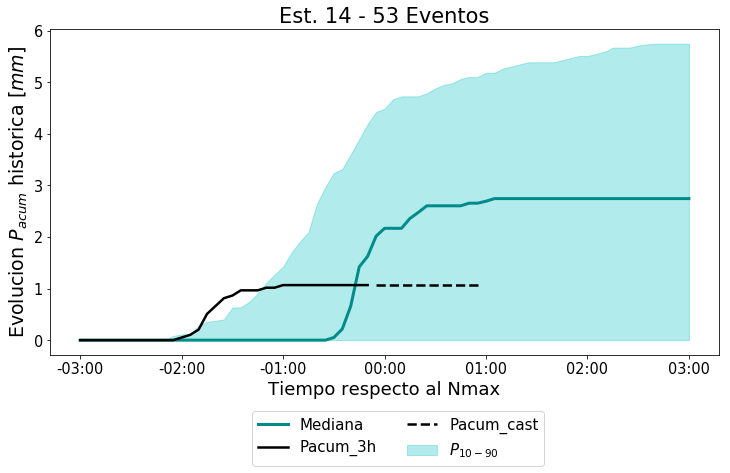

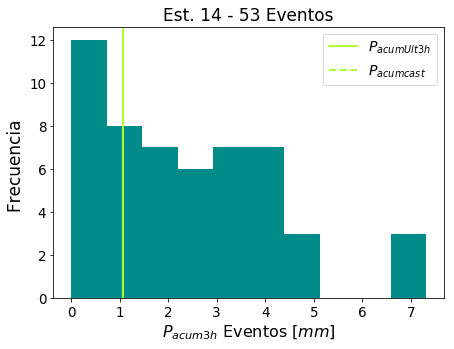

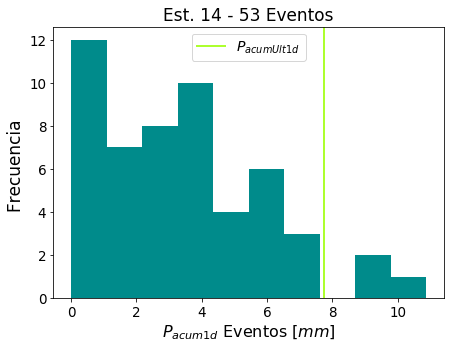

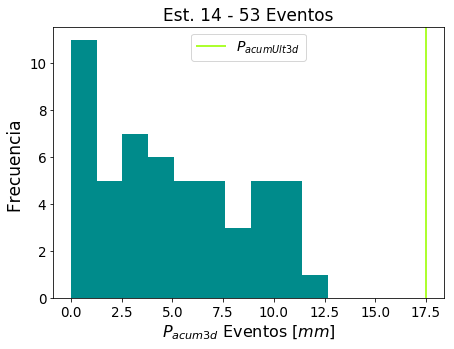

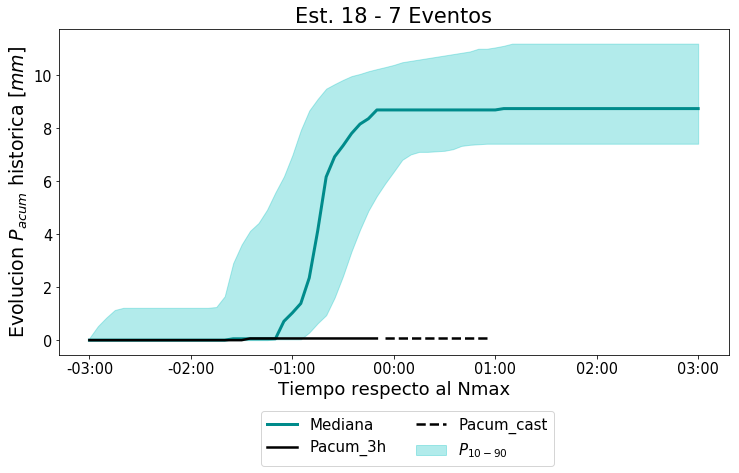

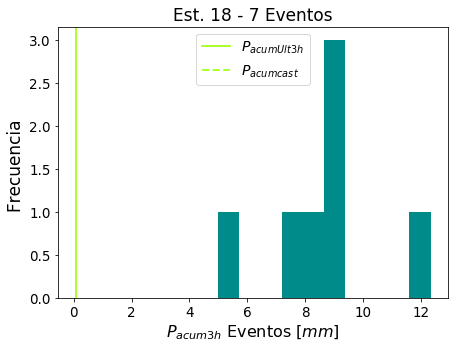

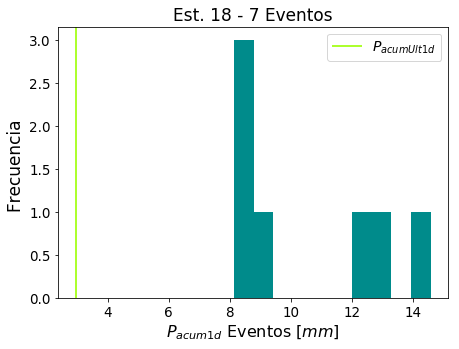

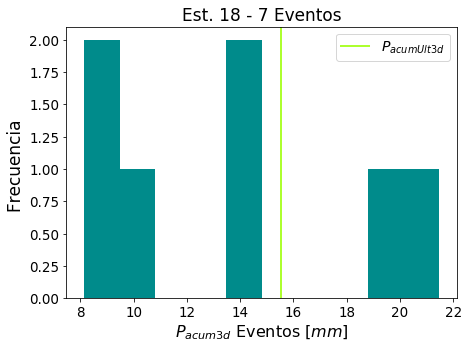

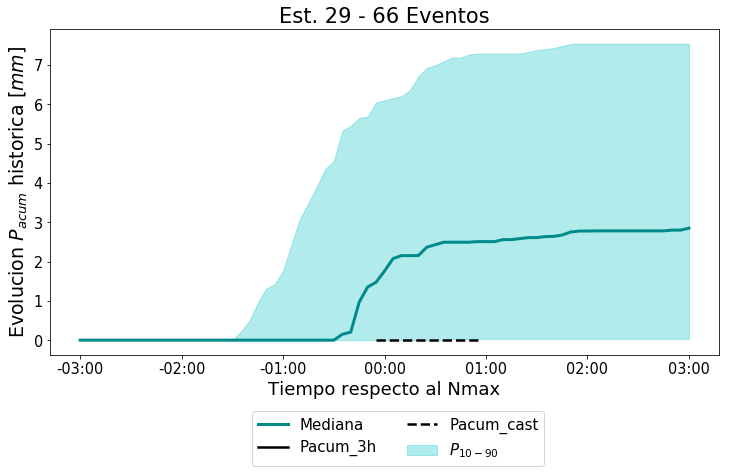

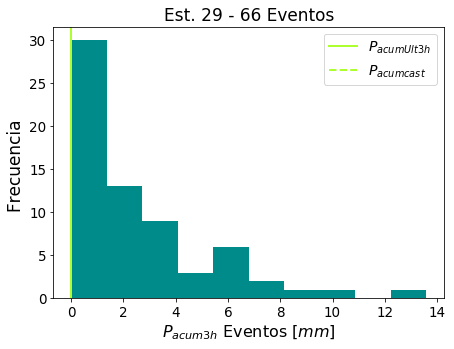

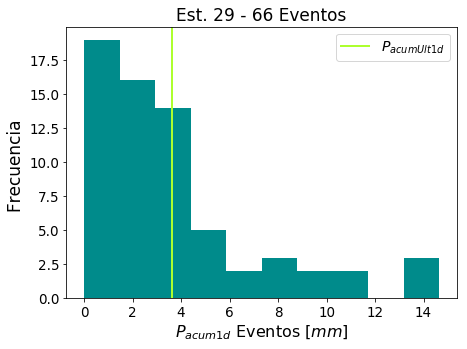

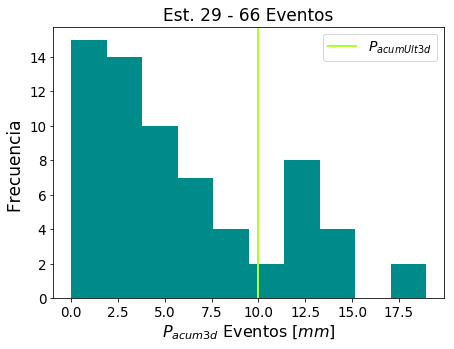

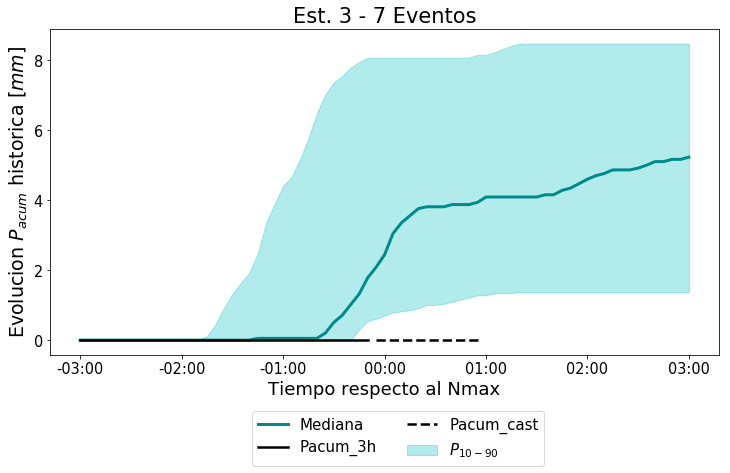

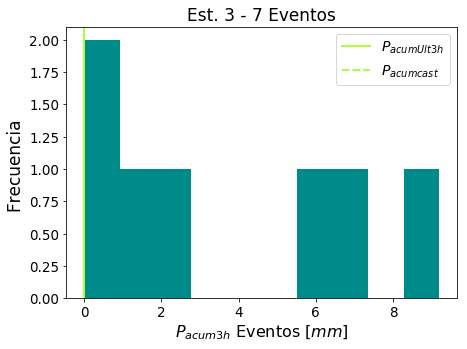

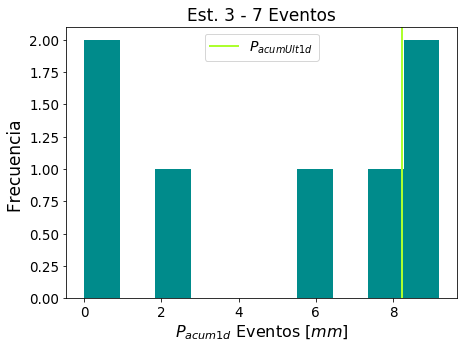

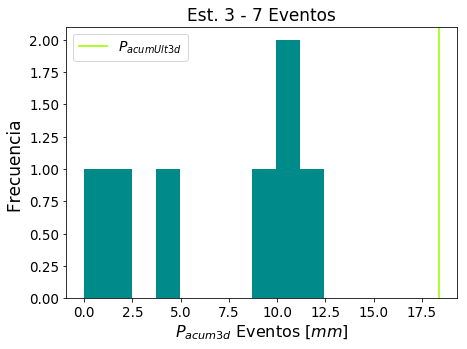

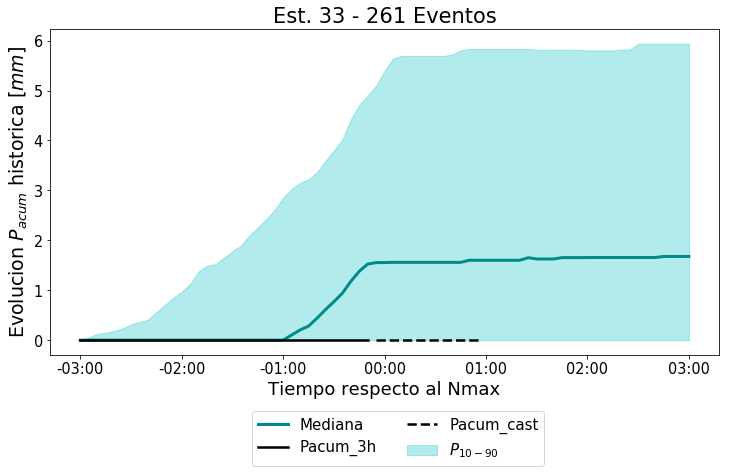

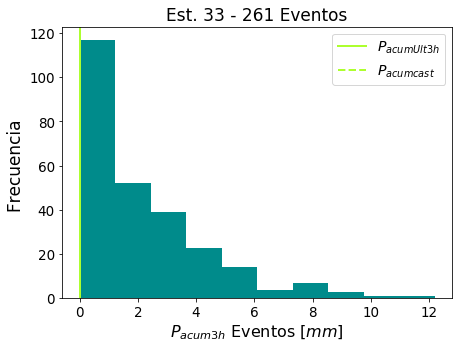

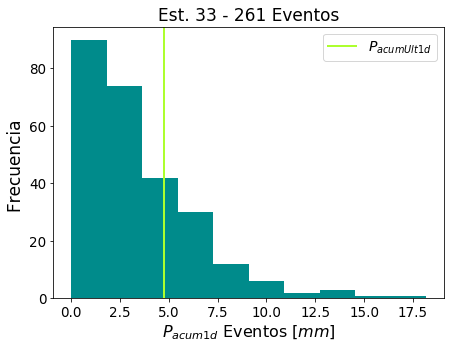

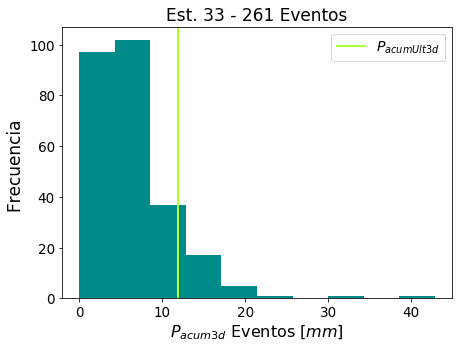

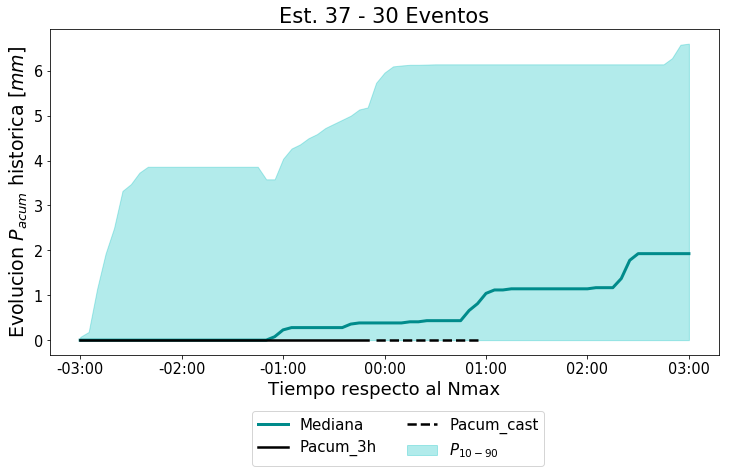

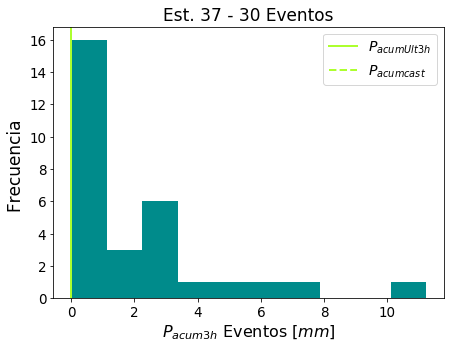

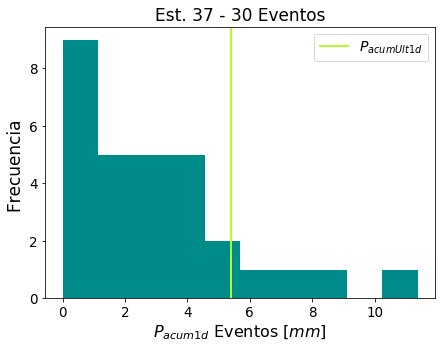

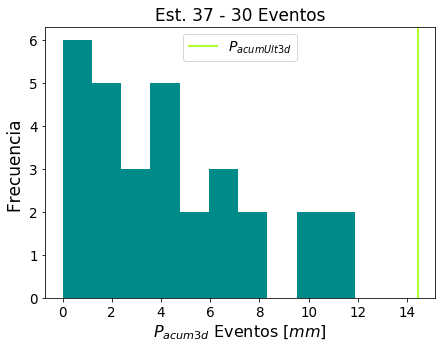

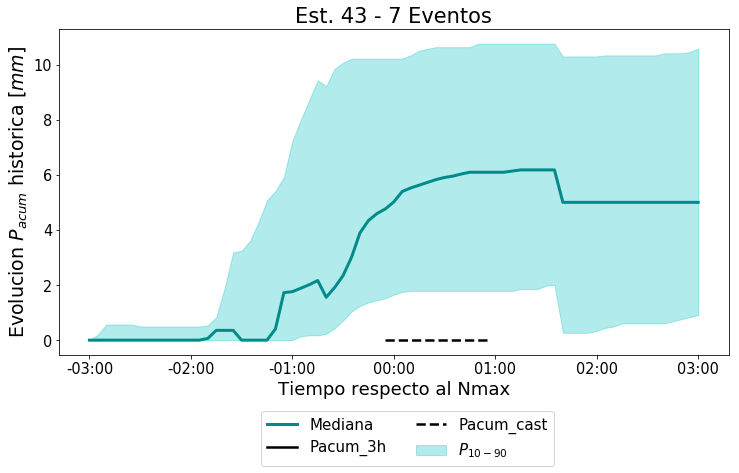

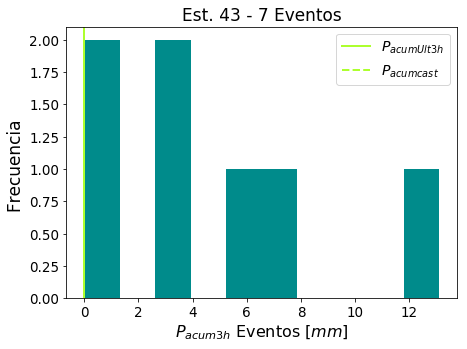

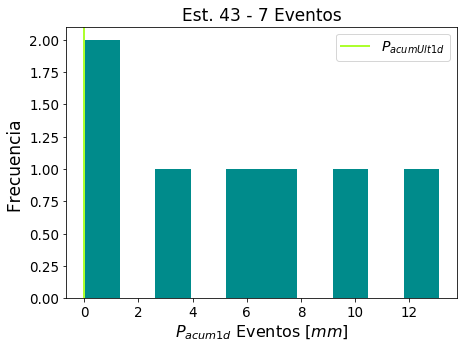

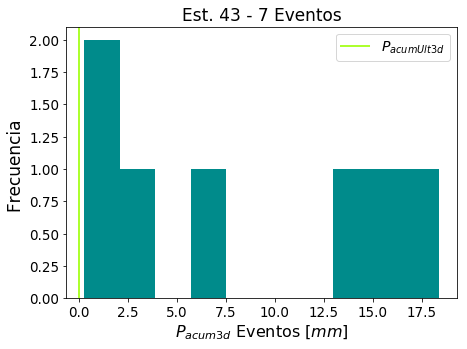

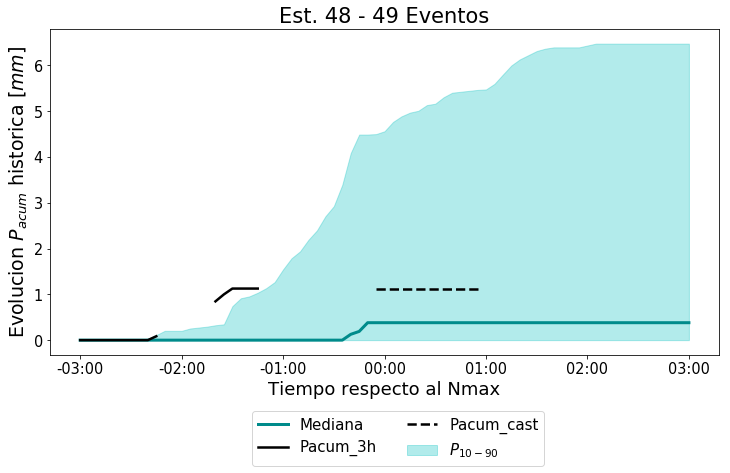

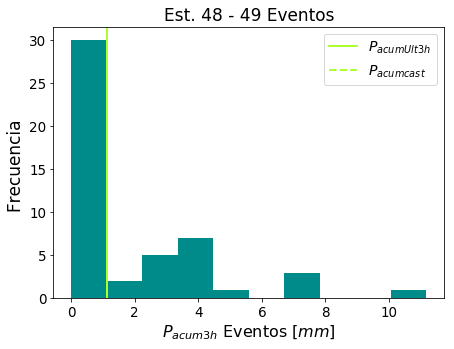

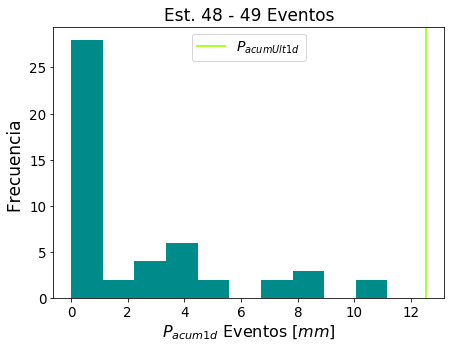

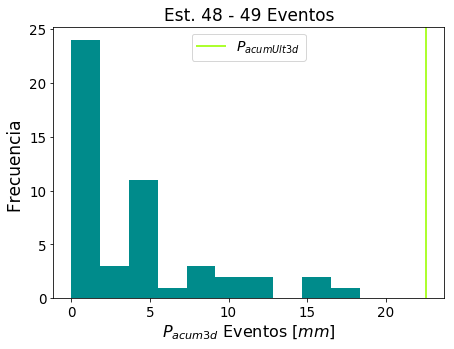

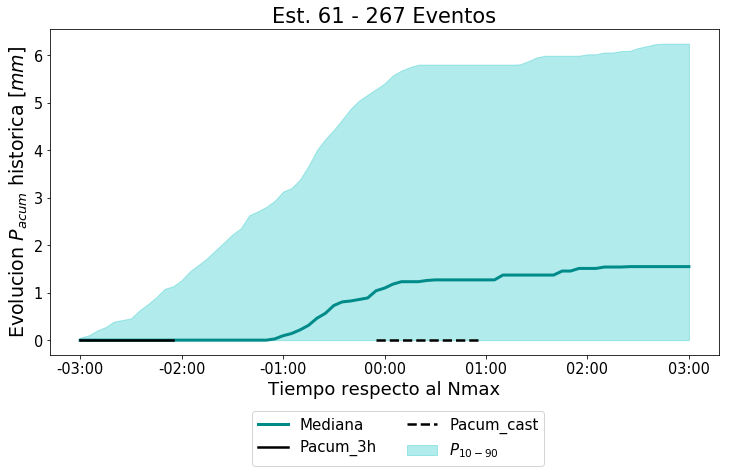

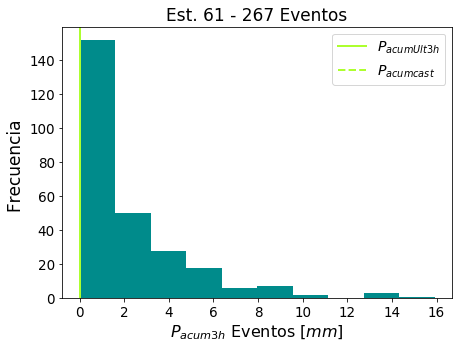

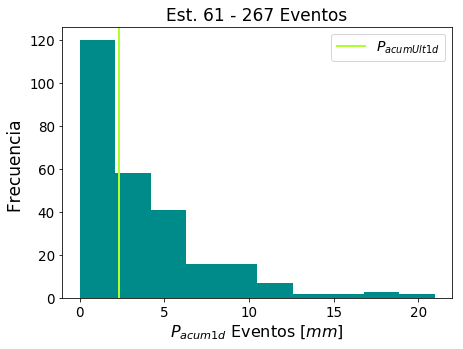

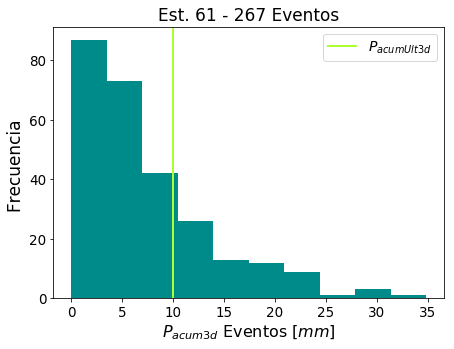

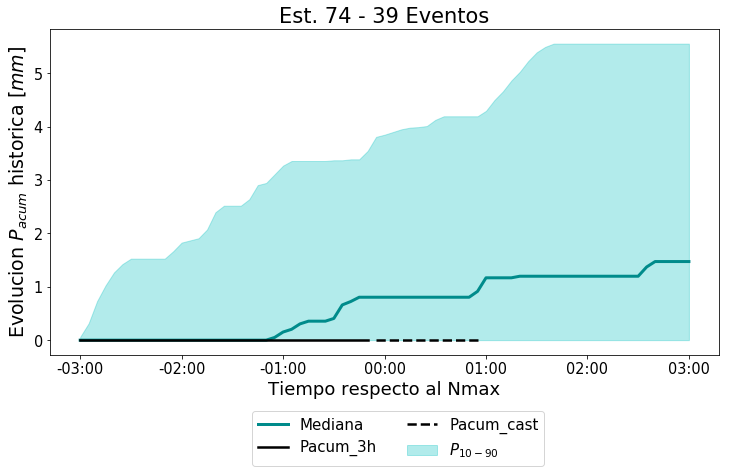

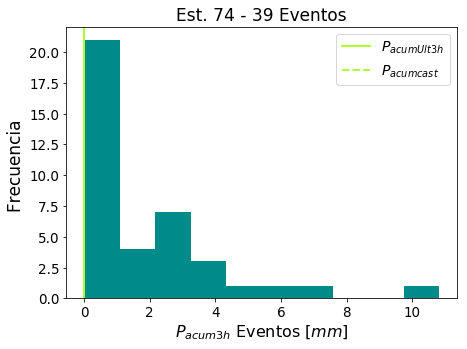

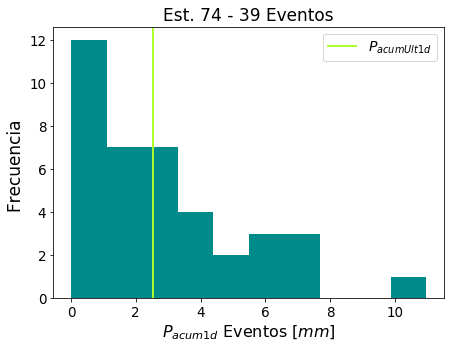

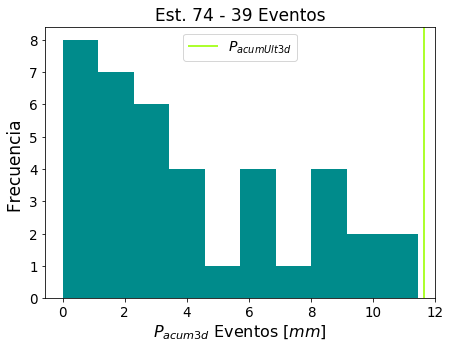

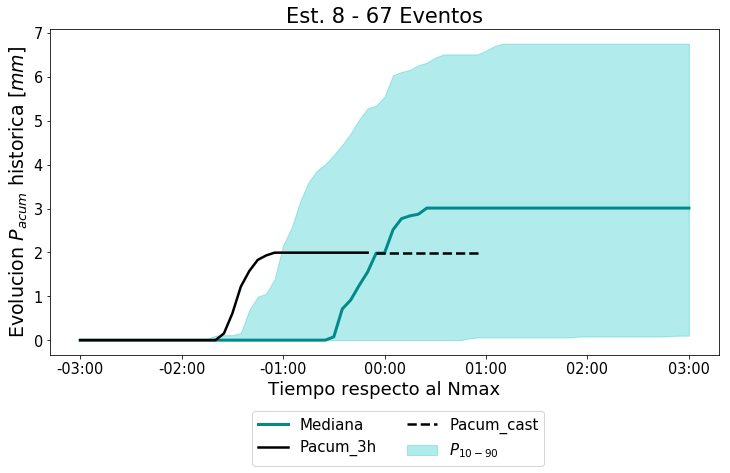

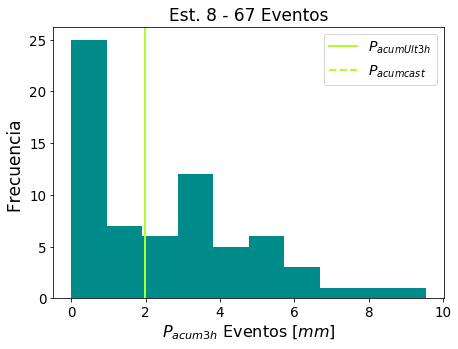

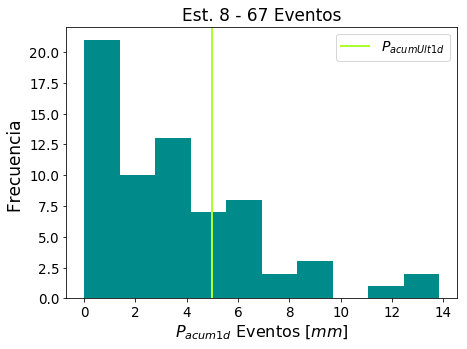

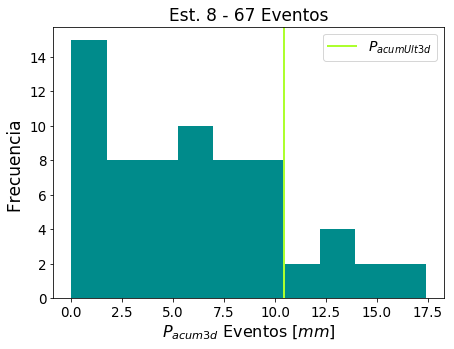

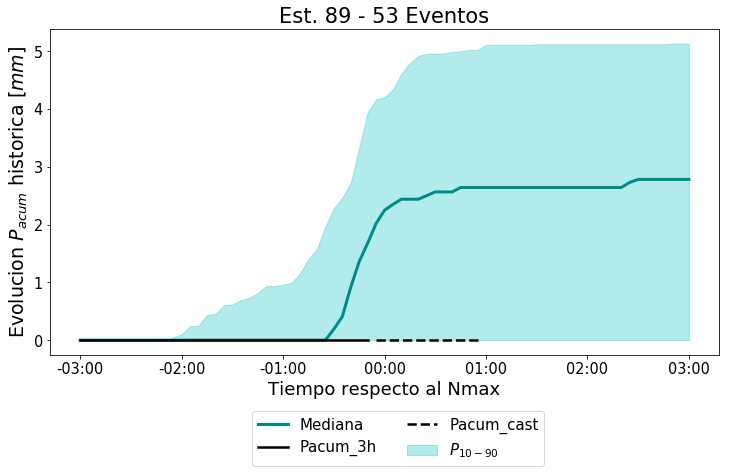

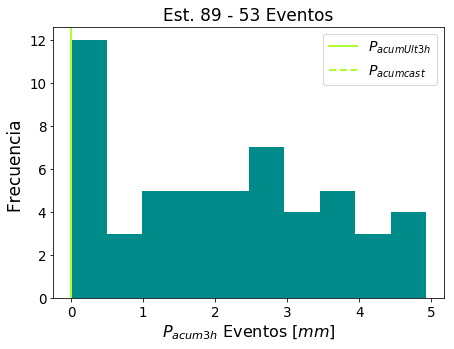

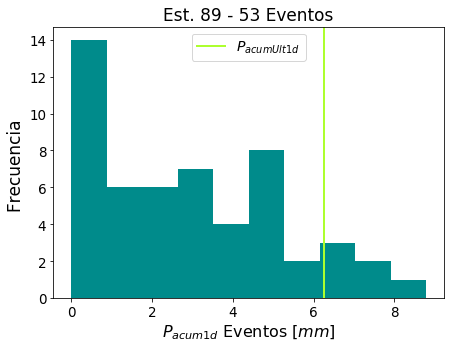

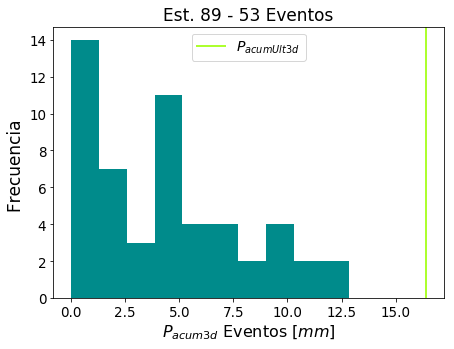

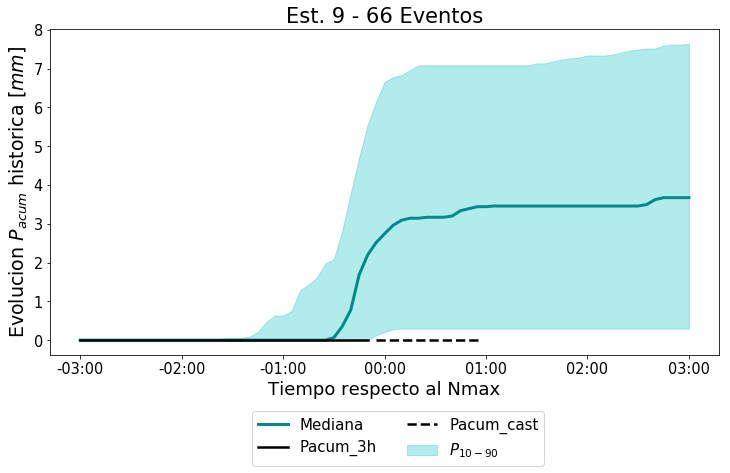

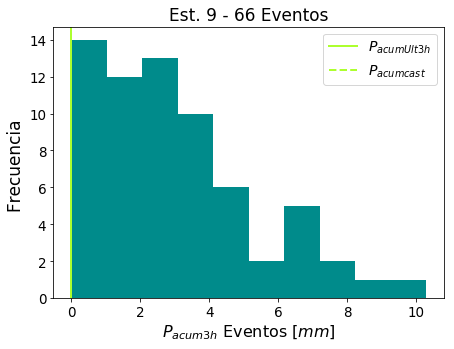

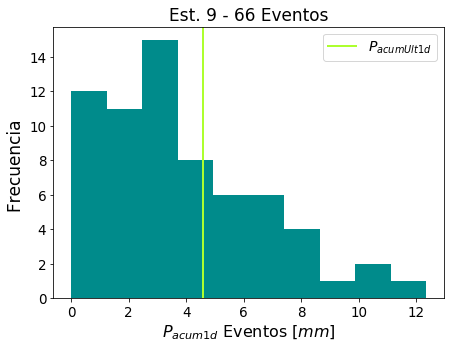

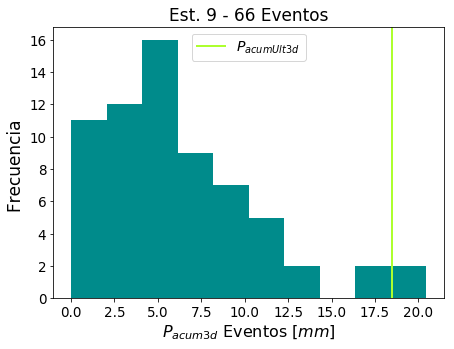

In [33]:
plotP_vs_History(rutaP_infoeventos,rutaFigsPbandas,cast_normal,rng1,timedeltaEv)

Prueba desde el modulo

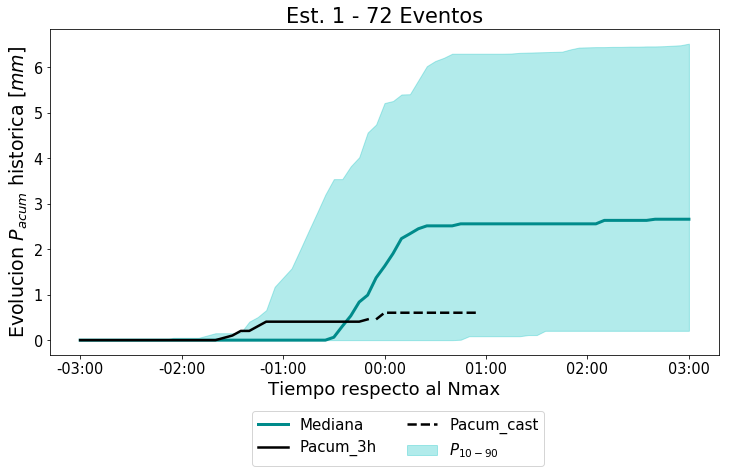

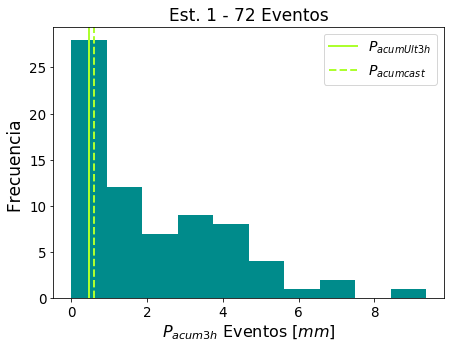

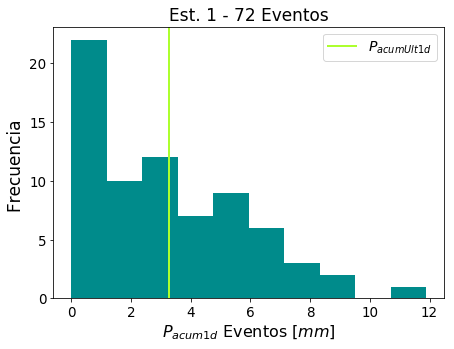

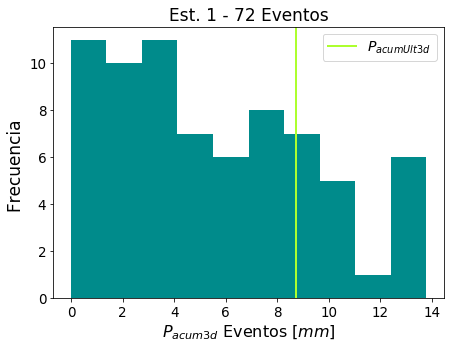

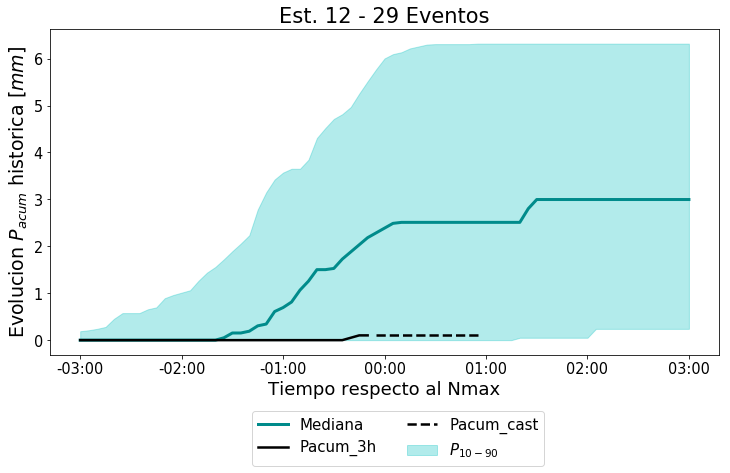

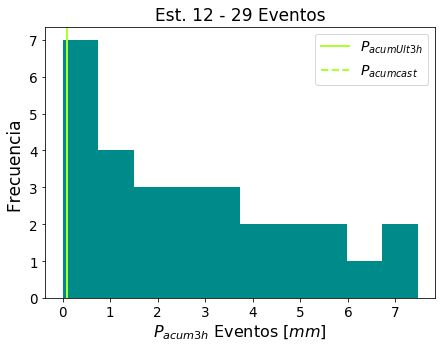

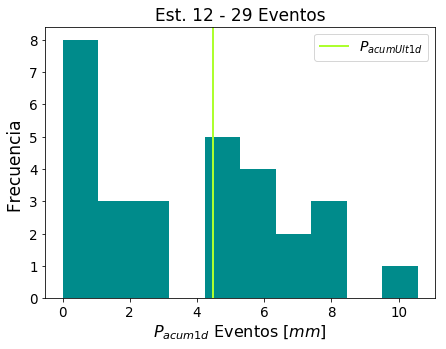

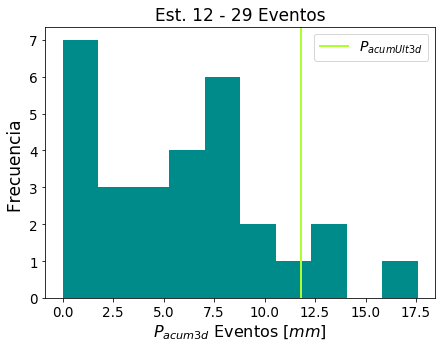

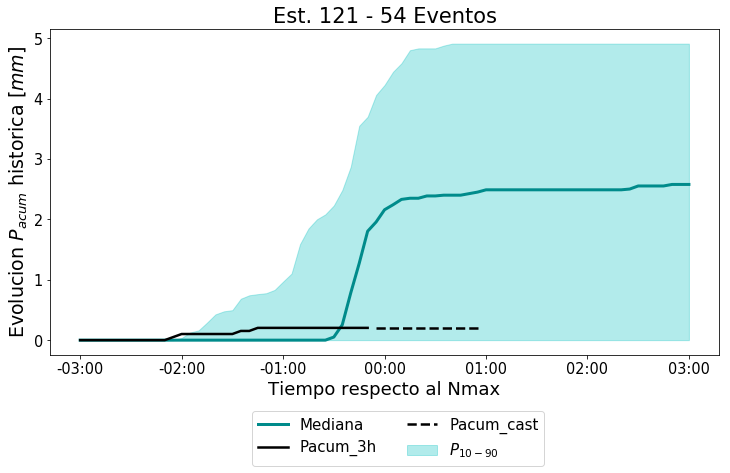

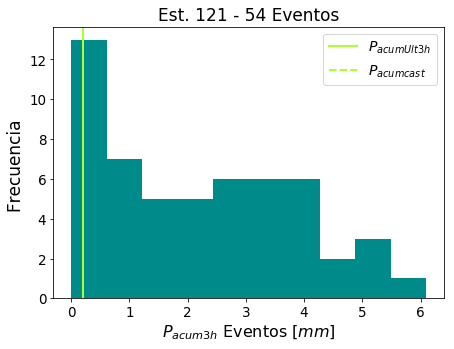

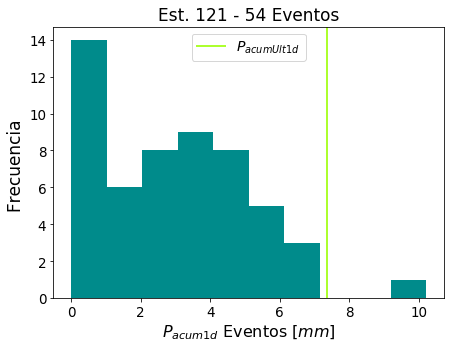

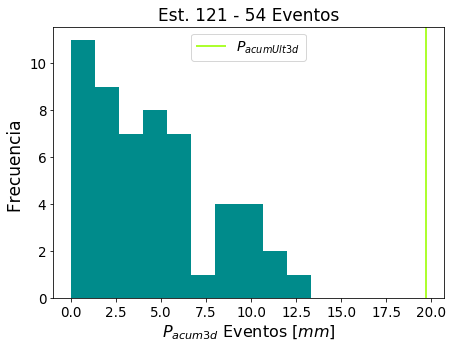

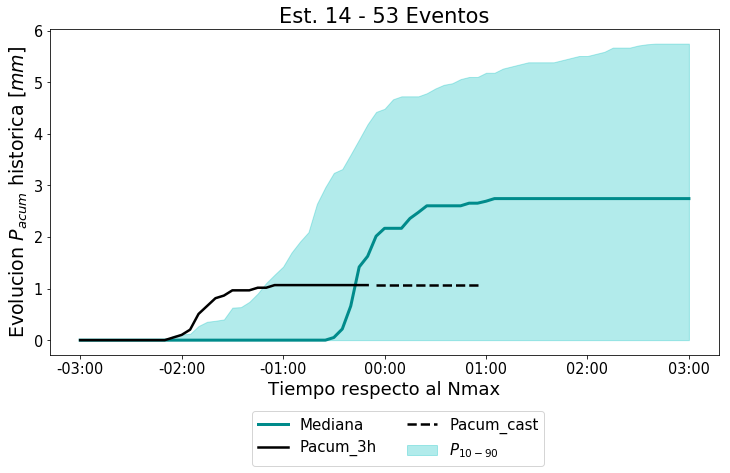

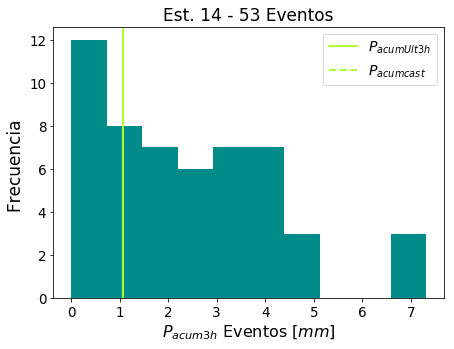

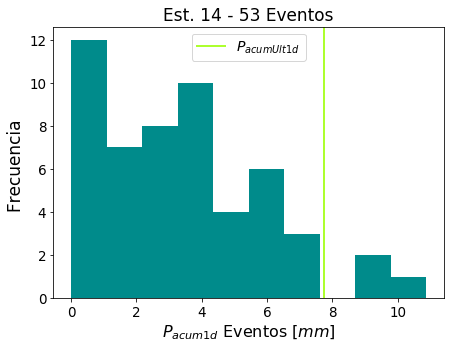

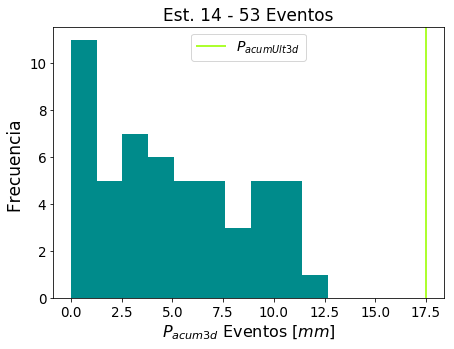

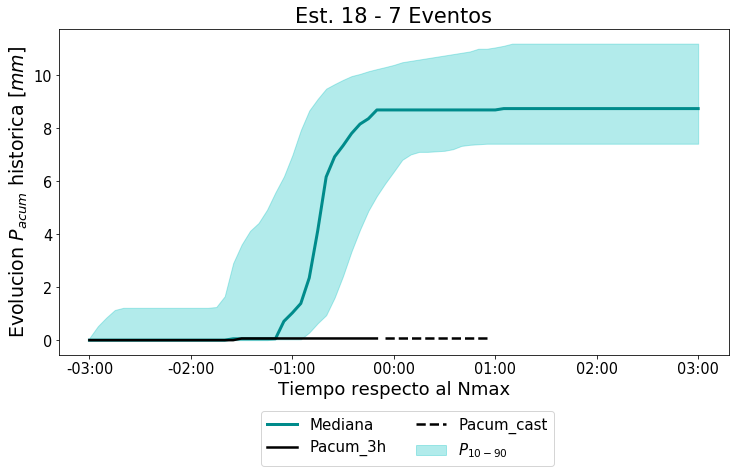

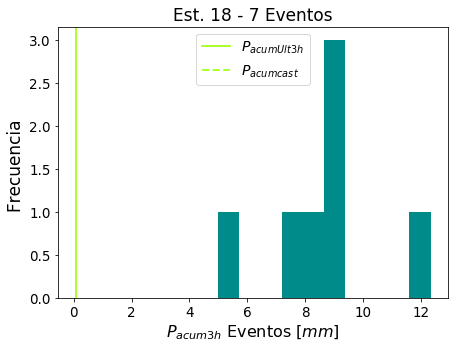

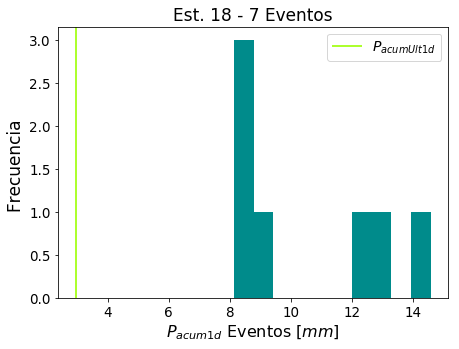

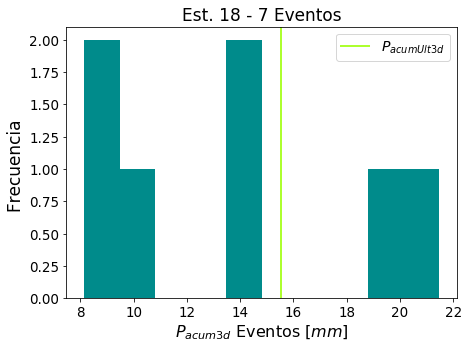

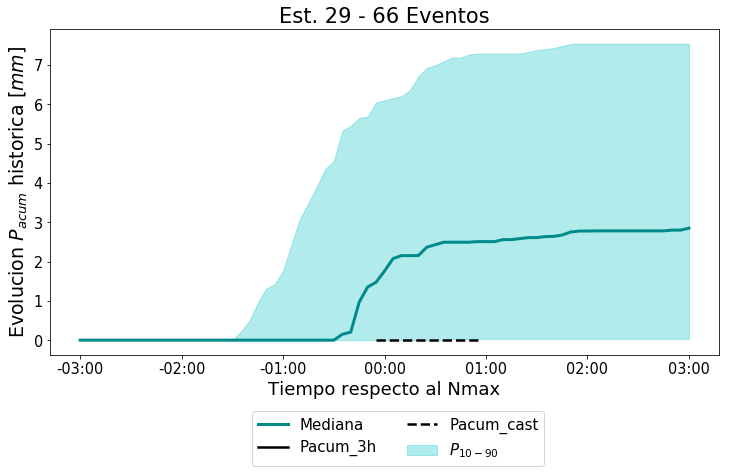

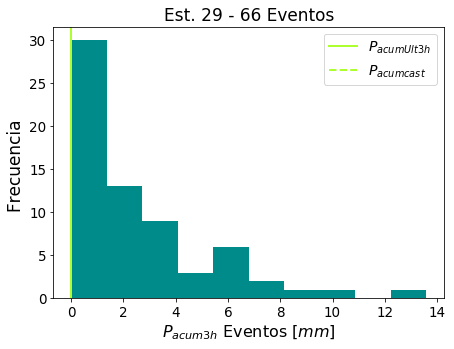

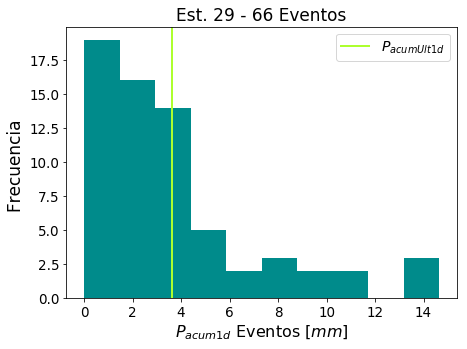

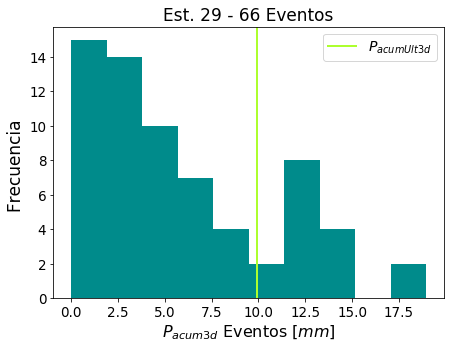

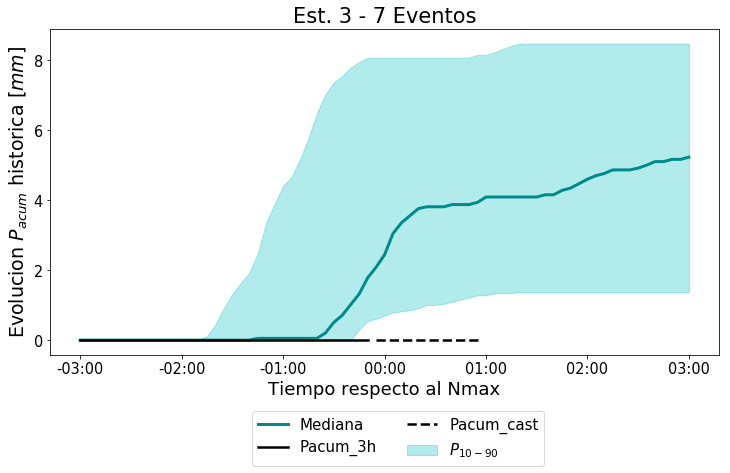

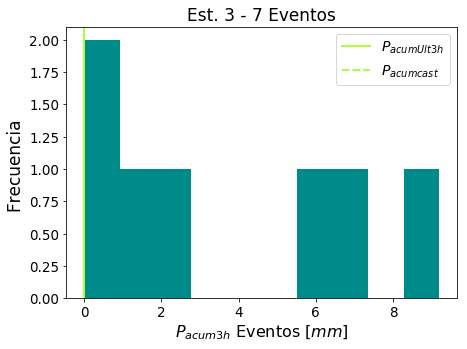

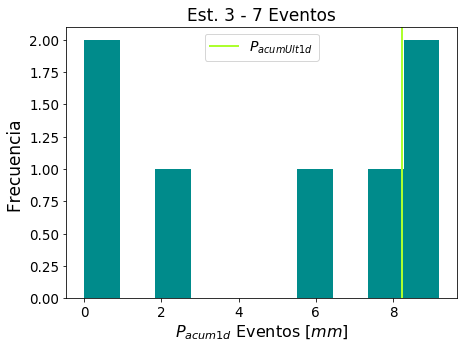

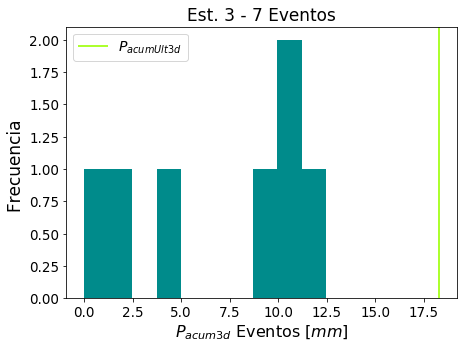

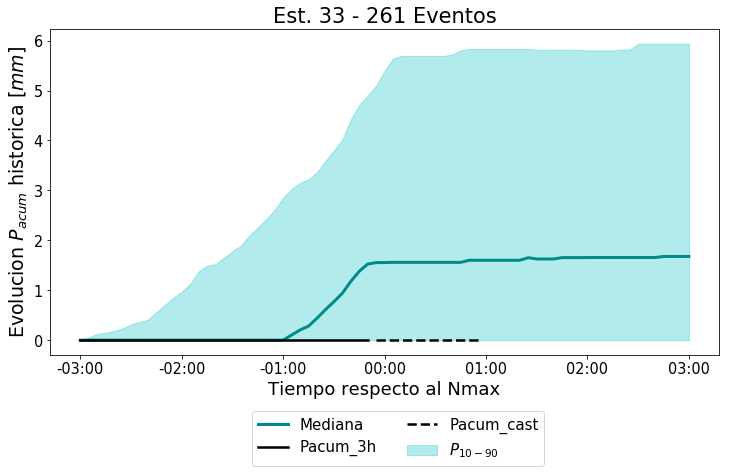

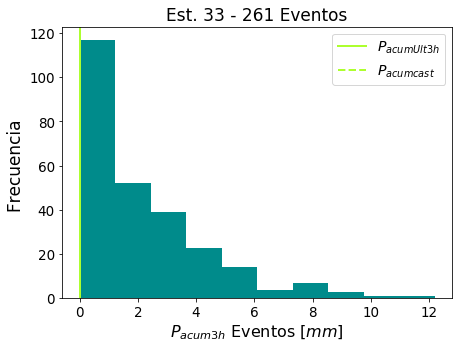

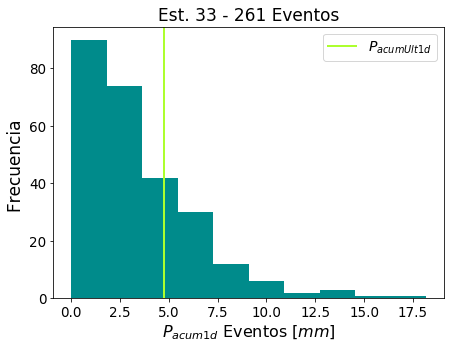

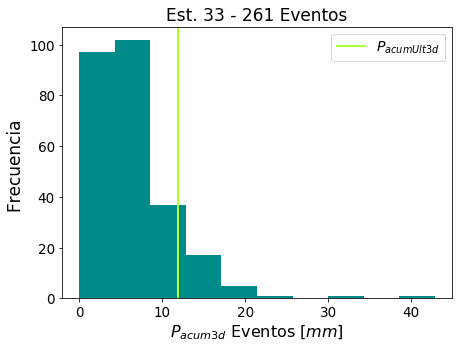

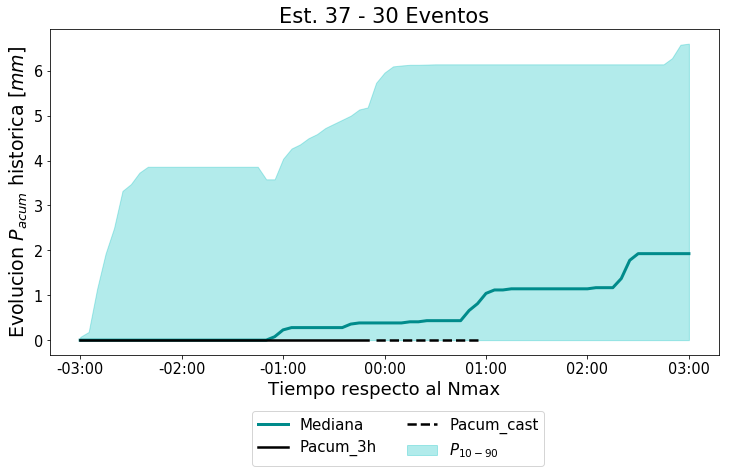

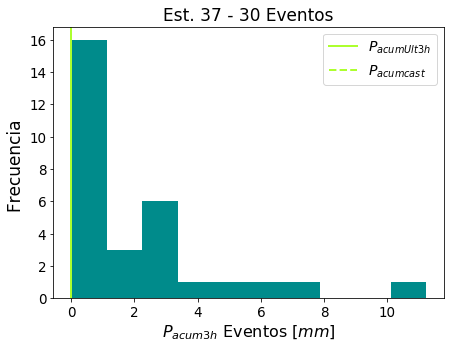

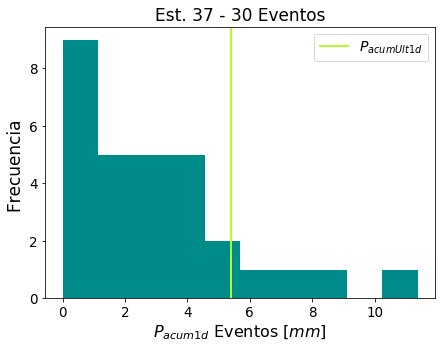

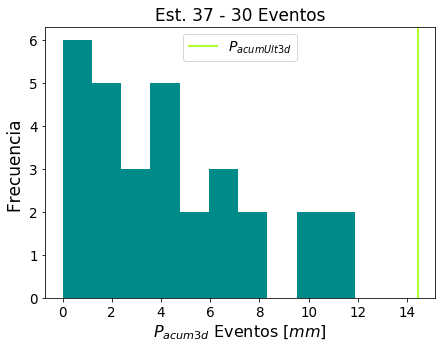

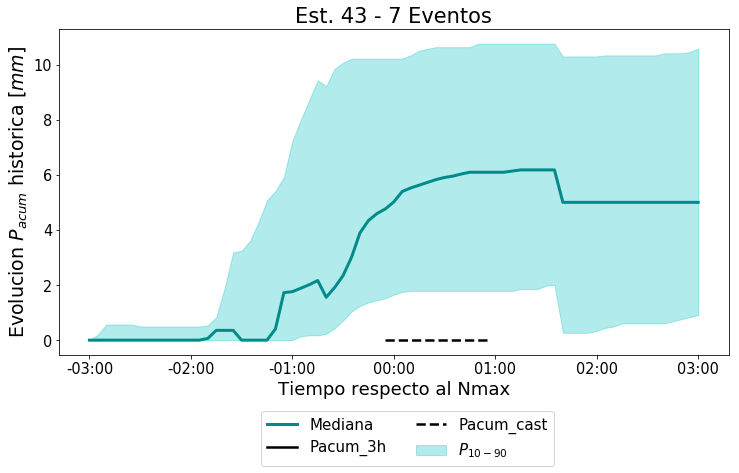

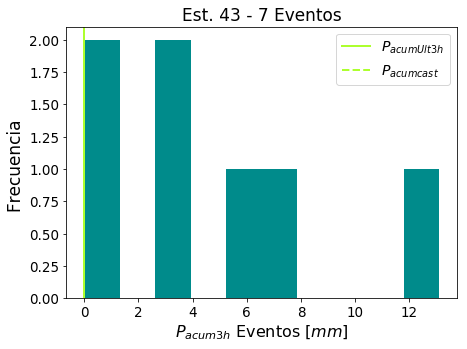

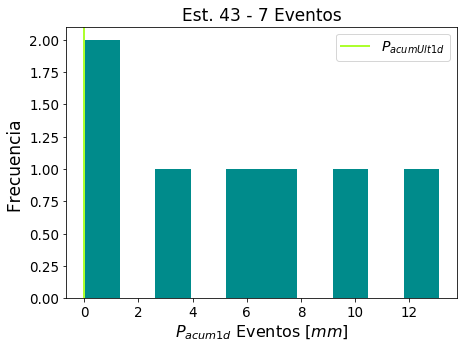

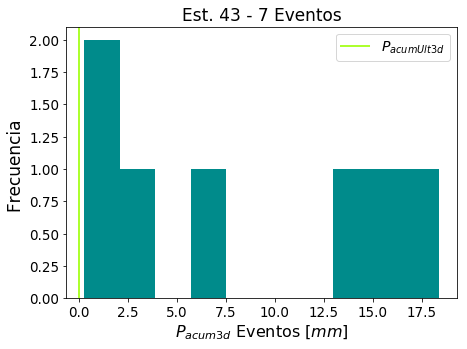

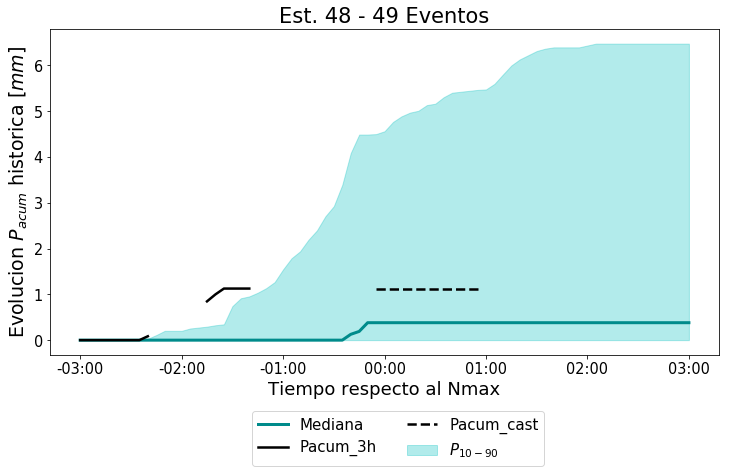

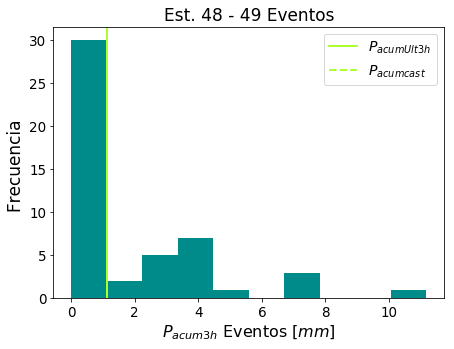

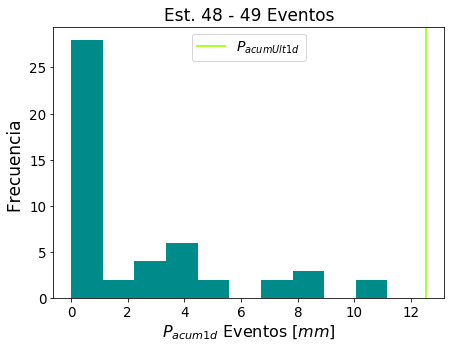

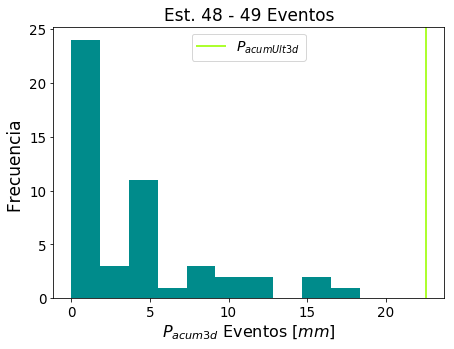

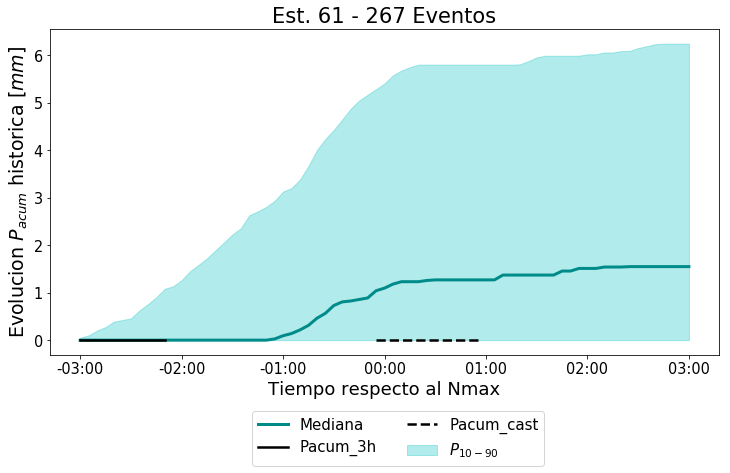

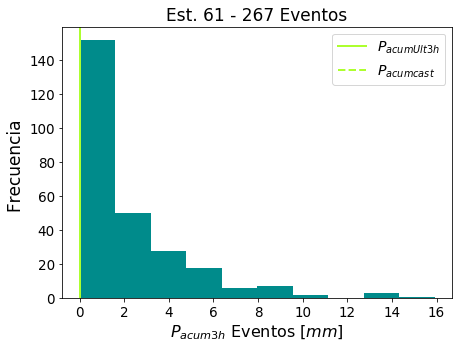

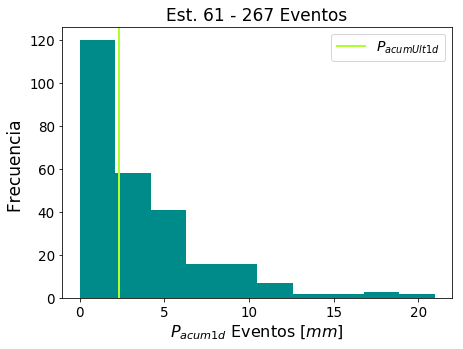

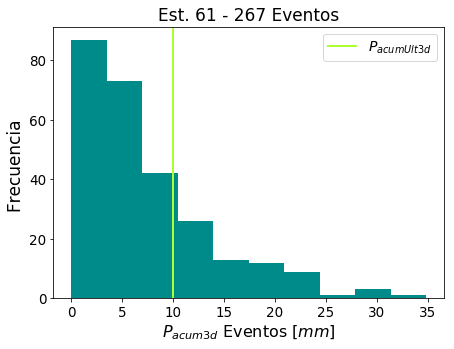

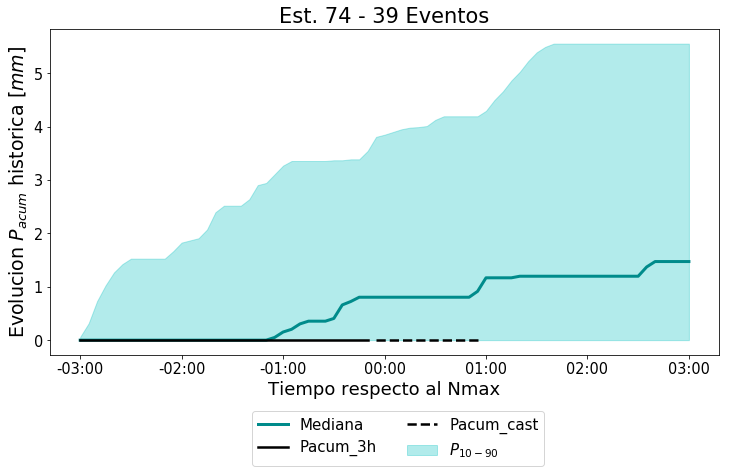

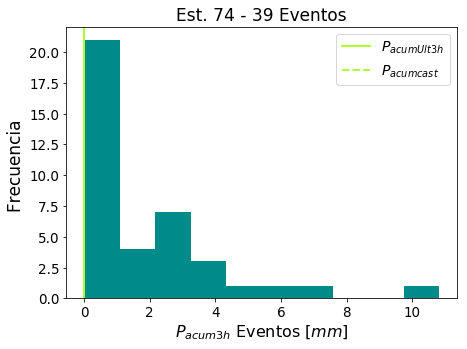

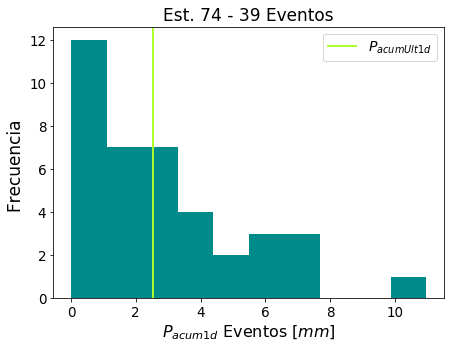

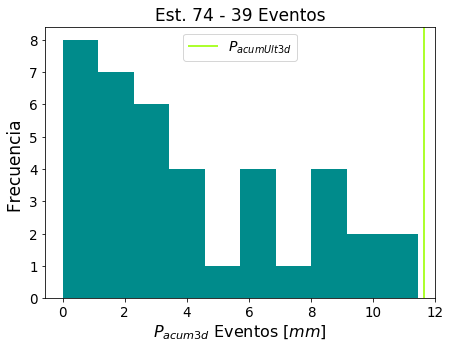

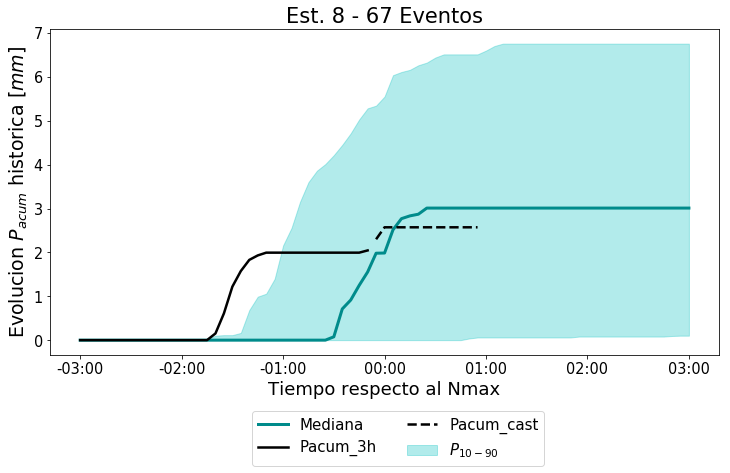

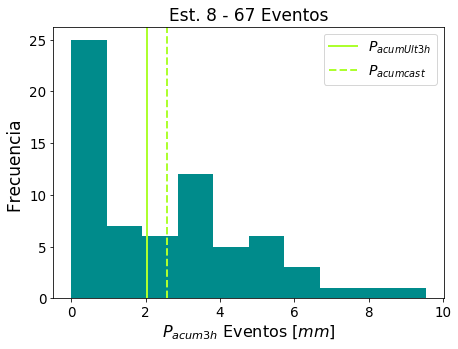

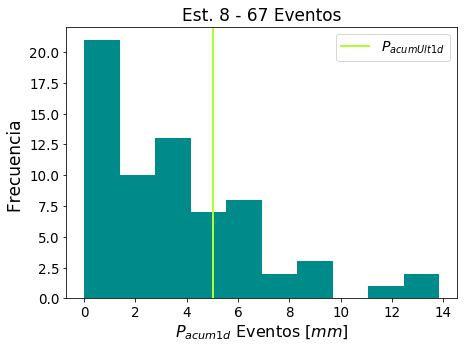

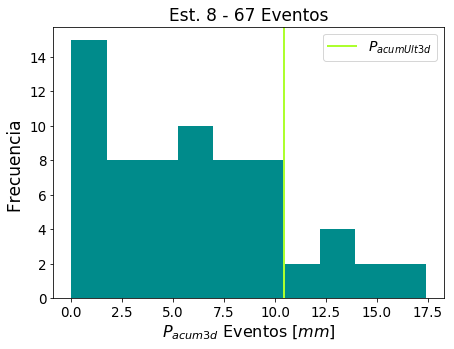

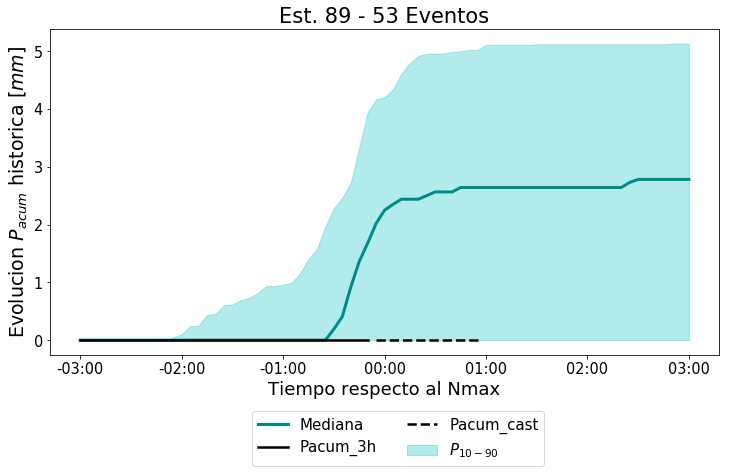

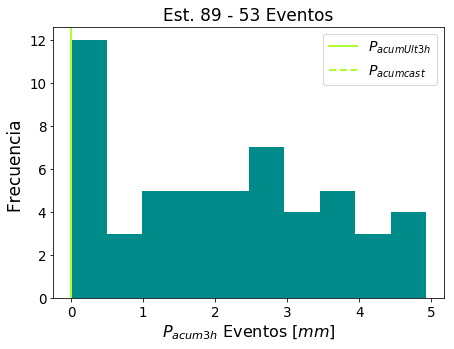

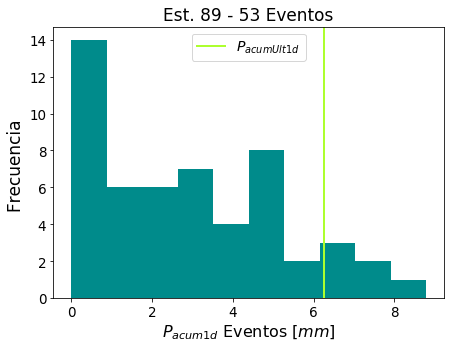

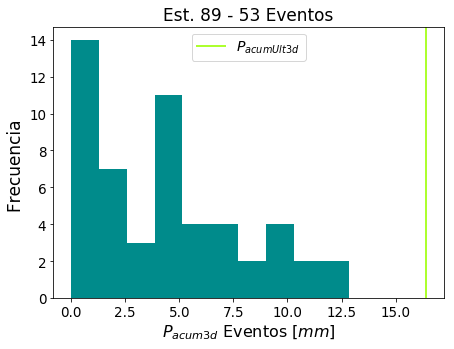

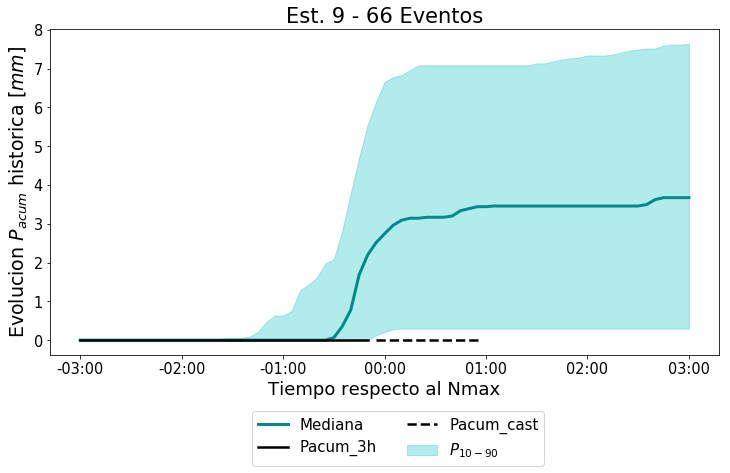

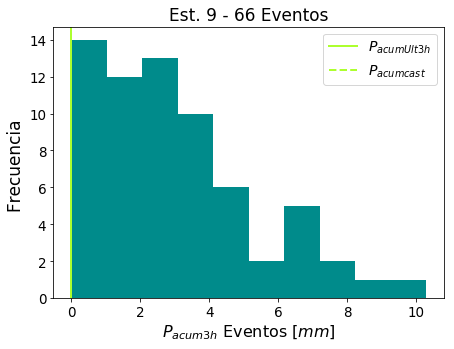

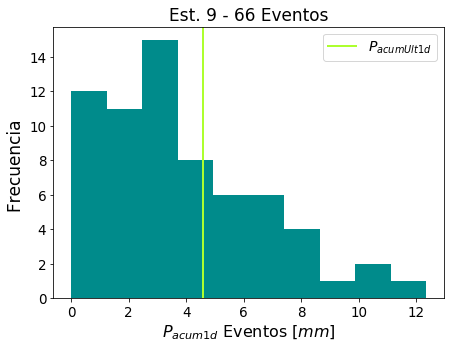

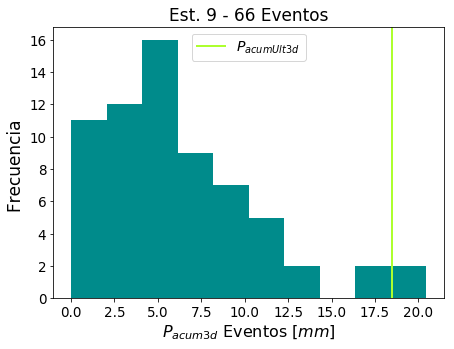

In [6]:
al.plotP_vs_History(rutaP_infoeventos,rutaFigsPbandas,cast_normal,rng1,timedeltaEv)

# ---

Así se sacaron las bandas P antes..

In [ ]:
if est in ests1:
    #La parte de las estP
    ests_p=np.append(np.hstack(dfconfig[dfconfig.index==sir]['EstPluvioAdentro']),np.hstack(dfconfig[dfconfig.index==sir]['EstPluvioAfuera']))
    ests_p=ests_p[np.where(ests_p)[0]]
    for est_p in ests_p:
        MatrizP=[];EvP=[];Pacum10=[];Pacum3=[];Pacum1=[];Pacum3h=[];Pmax3h=[]
        path_p=paths_p[str(est_p)]
        #se lee y organiza la serie
        seriep=pd.read_csv(path_p)
        seriep.index=pd.to_datetime(seriep[seriep.keys()[0]])
        seriep.index.name=''
        seriep=seriep.drop(seriep.keys()[0],axis=1)
        seriep.columns=['pluvio']
        seriep=seriep['pluvio']
        seriep=seriep.resample('5T').mean()
        #eventos
        for ev in Ev.index:
            #si la fecha  esta en la serie pluvio
            if ev in seriep.index:
                seriev=seriep[ev-pd.Timedelta(timeperiod):ev+pd.Timedelta(timeperiod)]
                #si mas del 40% son no  nan.
                if (seriev.dropna().size)/float(seriev.size) < 0.15:
                    pass
                else:
                    #si puede guarde los eventos, try porque las serie N y P no siempre coinciden.
                    try:
                        MatrizP.append(seriev.values)
                        Pacum10.append(seriep[ev-pd.Timedelta('10 days'):ev].sum())
                        Pacum3.append(seriep[ev-pd.Timedelta('3 days'):ev].sum())
                        Pacum1.append(seriep[ev-pd.Timedelta('1 days'):ev].sum())
                        Pacum3h.append(seriep[ev-pd.Timedelta('3 hours'):ev].sum())
                        Pmax3h.append(seriep[ev-pd.Timedelta('3 hours'):ev].max())
                        EvP.append(ev)
                    except:
                        pass
            #si no NaNs
            else:
                MatrizP.append(np.ones(seriev.size)*np.nan)
                Pacum10.append(np.nan)
                Pacum3.append(np.nan)
                Pacum1.append(np.nan)
                Pacum3h.append(np.nan)
                Pmax3h.append(np.nan)
                EvP.append(ev)

        #hietrogramas.
        dfpluvio=pd.DataFrame(MatrizP).T
        dfpluvio.columns=(map(str,EvP))
#         dfpluvio.to_csv('historicos/pluvio/eventos/eventos_'+str(est_p)+'.csv')

        #bandas - acumulacionP
        dfpluvio=dfpluvio.fillna(method='ffill')
        Pbandas=pd.DataFrame([dfpluvio.cumsum().T.quantile(0.1),dfpluvio.cumsum().T.quantile(0.25),dfpluvio.cumsum().T.quantile(0.5),dfpluvio.cumsum().T.quantile(0.75),dfpluvio.cumsum().T.quantile(0.9)]).T
#         Pbandas.to_csv('historicos/pluvio/eventos/bandas_'+str(est_p)+'.csv')

        Pacum=pd.DataFrame([Pacum3h,Pacum1,Pacum3,Pacum10,Pmax3h])
        Pacum.index=['Pacum3h','Pacum1','Pacum3','Pacum10','Pmax3h']
        Pacum.columns=(map(str,EvP))
#         Pacum.to_csv('historicos/pluvio/eventos/Pacum_'+str(est_p)+'.csv') 